In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from math import sqrt
from tqdm import tqdm

from scipy import stats

from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import shap
shap.initjs()

import joblib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Wczytanie danych

In [2]:
data = pd.read_excel('default_of_credit_card_clients.xls', header=1)
data.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0         0                           1  
1      1000         0      2000                           1  
2      1000      1000      5000                           0  
3      1100      1069      1000                           0  
4      9000       689       679                           0  

[5 rows x 25 columns]

# Przygotowanie i wstępna analiza danych

Usunięcie kolumny ID - niepotrzebna w dalszej analizie

In [3]:
data.drop('ID',axis=1,inplace=True)

Opis kolumn analizowanego zbioru danych:

"LIMIT_BAL" - wartość udzielonych klientowi kredytów (USD)

"SEX" - płeć
    1=mężczyzna
    2=kobieta

"EDUCATION" - poziom wykształcenia klienta
    1=studia podyplomowe
    2=wykształcenie wyższe
    3=wykształcenie średnie
    4=inne

"MARRIAGE" - stan cywilny klienta
    1=żonaty/zamężna
    2=kawaler/panna
    3=inne

"AGE" - wiek klienta

"PAY_0"-"PAY_6" - informacja o terminowości dokonanych przez klienta spłatach zadłużenia od kwietnia do września 2005 roku; PAY_0 zawiera info o płatnościach za wrzesień 2005, ... PAY_6 o płatnościach za kwiecień 2005; kolumny zawierają wartości -2, -1, 0=terminowa płatność, 1=płatność opóźniona o miesiąc, 2=płatność opóźniona o dwa miesiące, ....... 9=płatność opóźniona o 9 miesięcy i więcej

"BILL_AMT1"-"BILL_AMT6" - stan rachunku klienta, w dolarach; BILL_AMT1 zawiera stan rachunku we wrześniu 2005, .... BILL_AMT6 stan rachunku w kwietniu 2005

"PAY_AMT1"-"PAY_AMT6" - wartość dokonanych płatności, w dolarach;  PAY_AMT1 zawiera wartość płatności we wrześniu 2005, .... PAY_AMT6 wartość płatności w kwietniu 2005

"default payment next month" - kolumna prezentuje zmienną opisywaną y, jest to decyzja o przyznaniu karty kredytowej klientowi; zawiera dwie wartości 0=przyznać kartę, 1=nie przyznawać karty (Uwaga! nagłówek kolumny tłumaczę jako odmowa przyznania płatności/linii kredytowej, w związku z czym 1='Yes' oznacza nieprzyznanie linii kredytowej, a 0='No' przyznanie linii kredytowej)

-------------------------------------------------------------------------------------------------------------------------------

Sprawdzenie czy występują wartości brakujące.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

Sprawdzenie czy dane się powtarzają, jeśli tak to ich usunięcie.

In [5]:
print(f"Jest {data.duplicated().sum()} powtarzających się danych.")

data = data.drop_duplicates()
print("Powtarzające się dane zostały usunięte.")

Jest 35 powtarzających się danych.
Powtarzające się dane zostały usunięte.


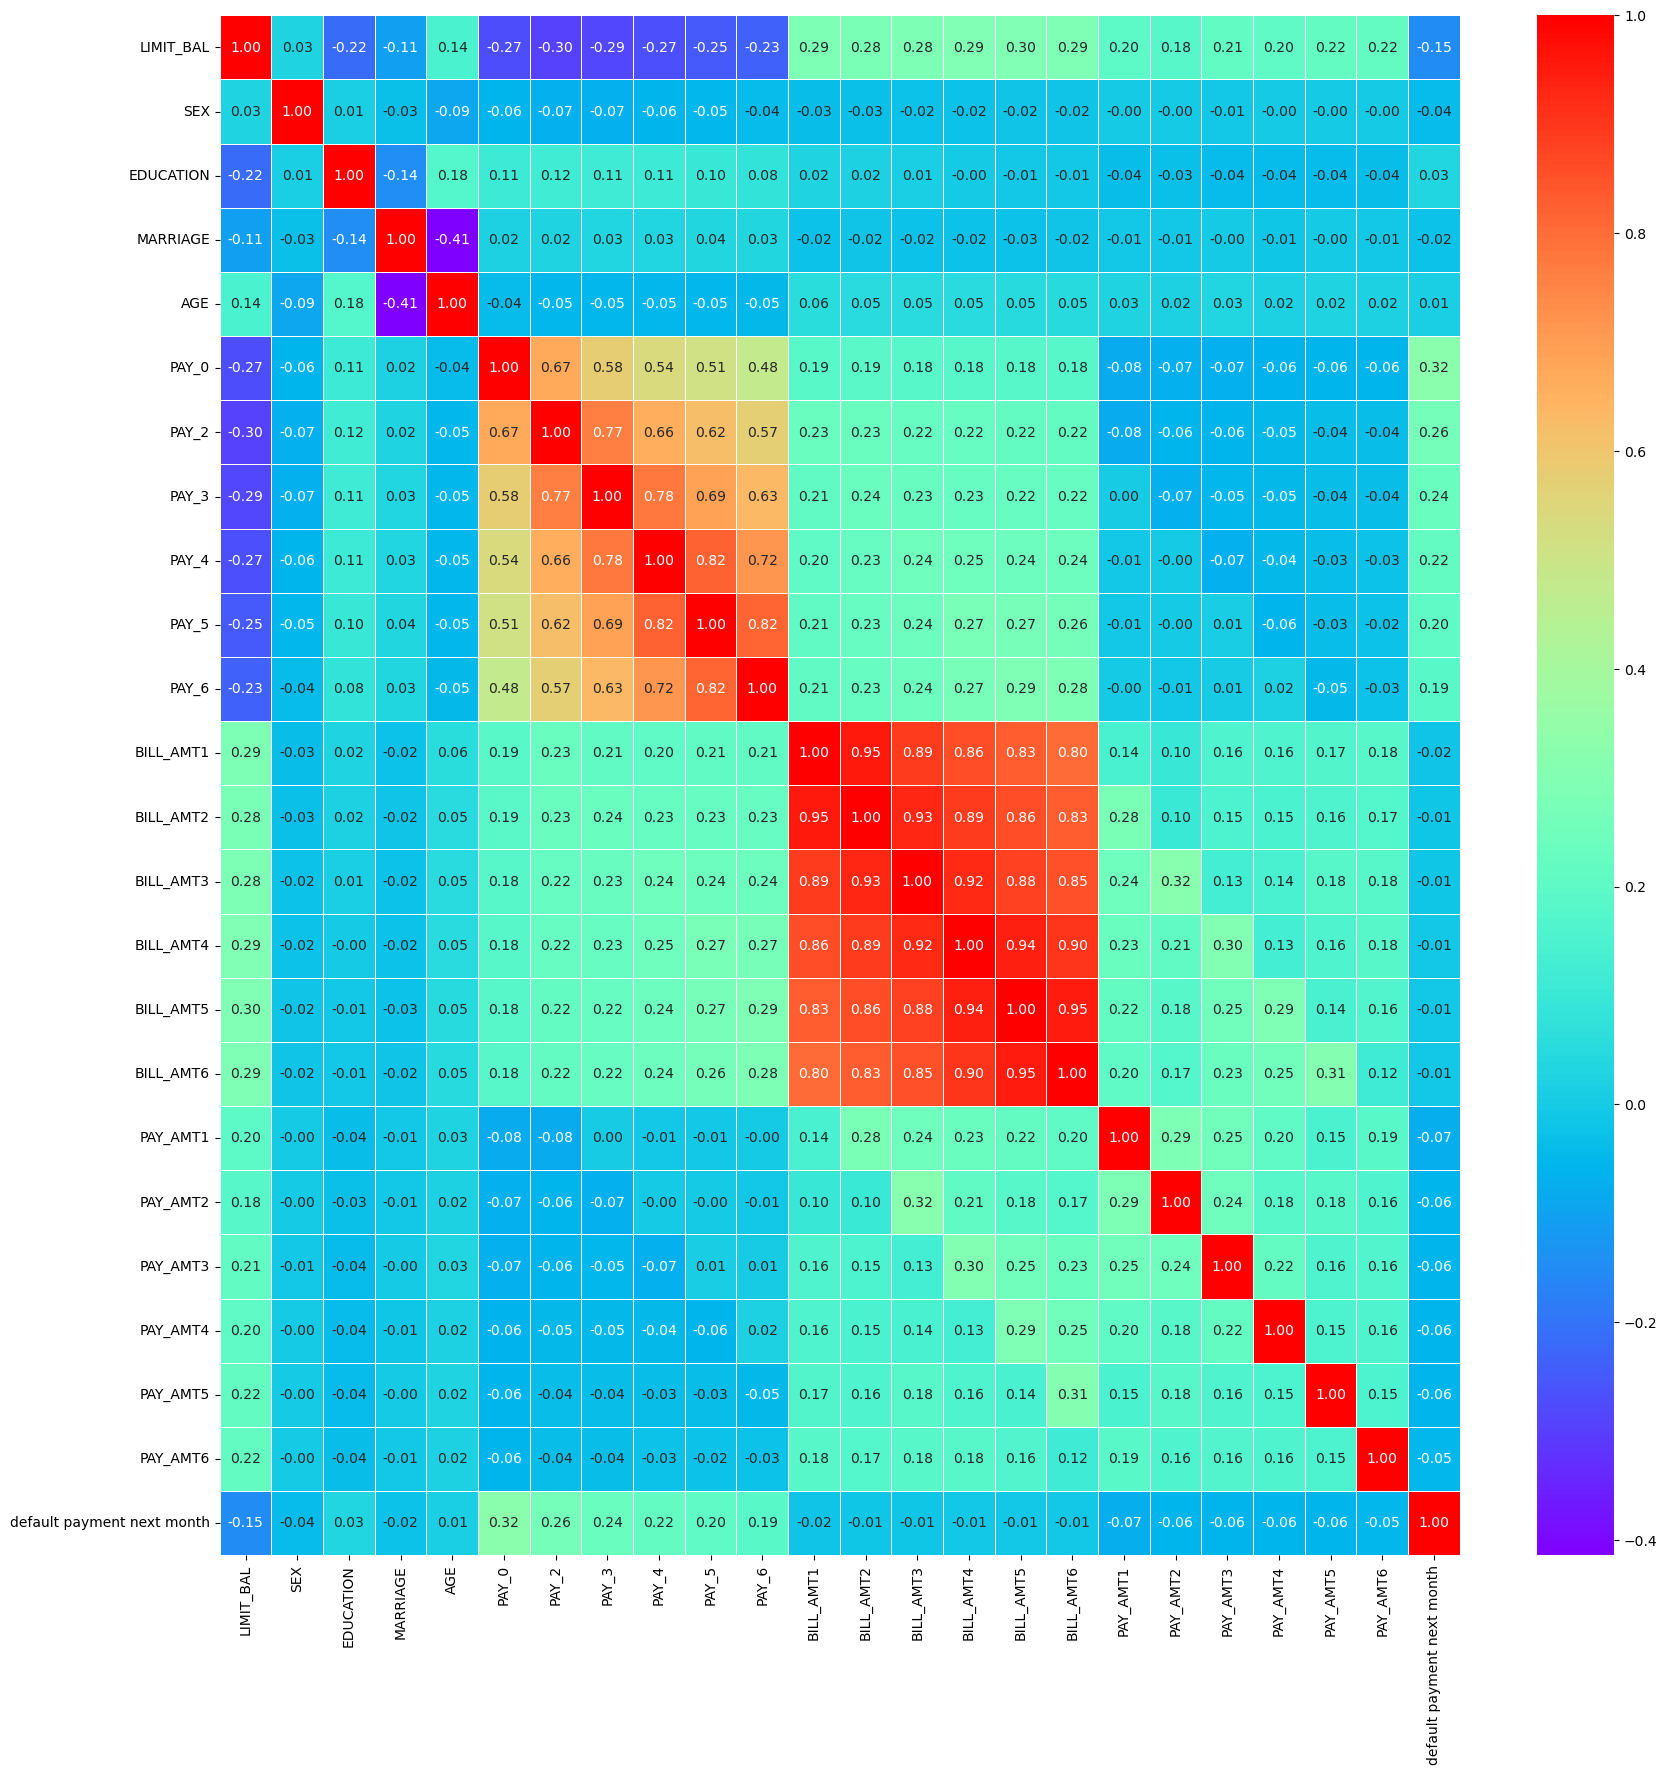

In [6]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),annot=True, cmap='rainbow',linewidth=0.5, fmt='.2f');

Histogramy i wykresy pudełkowe dla zmiennych numerycznych.

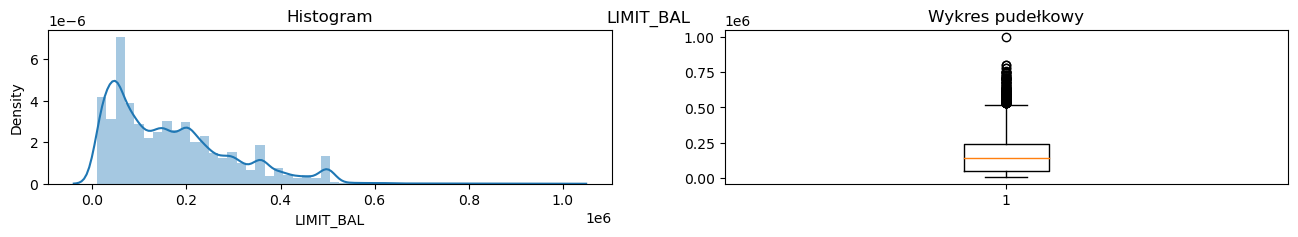

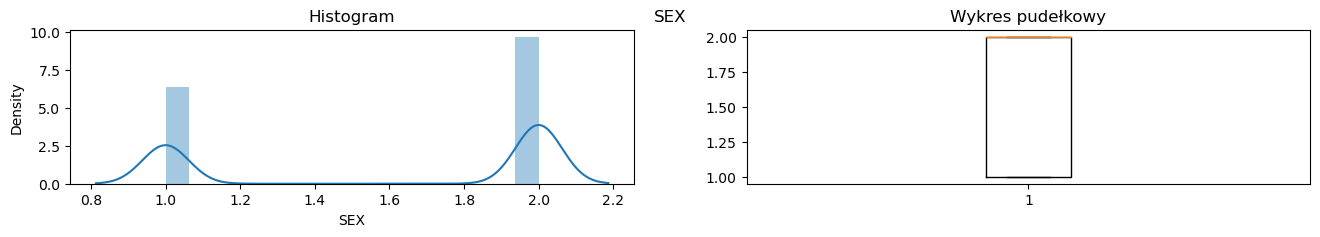

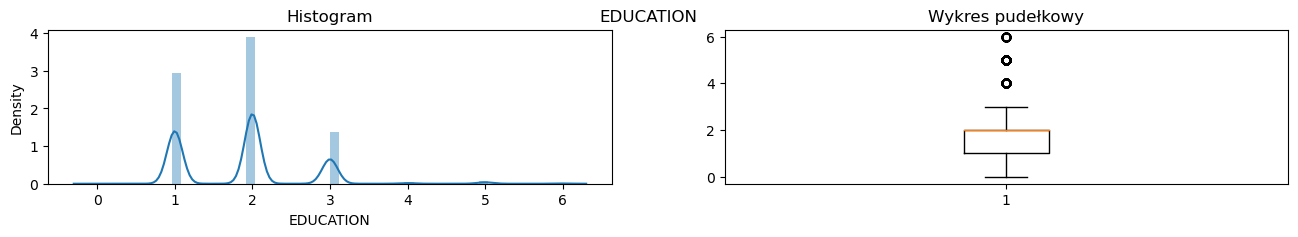

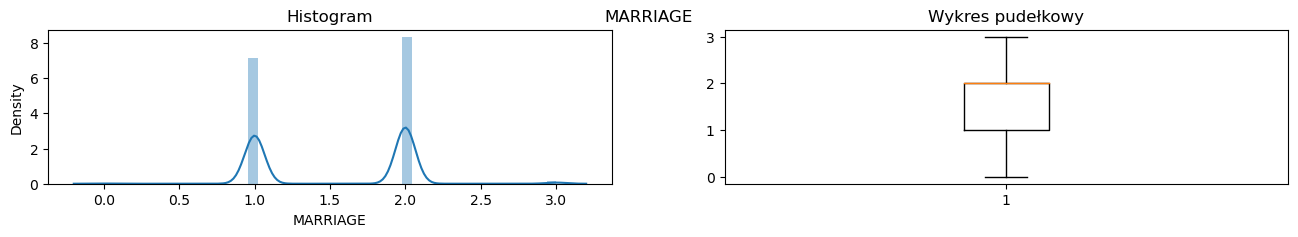

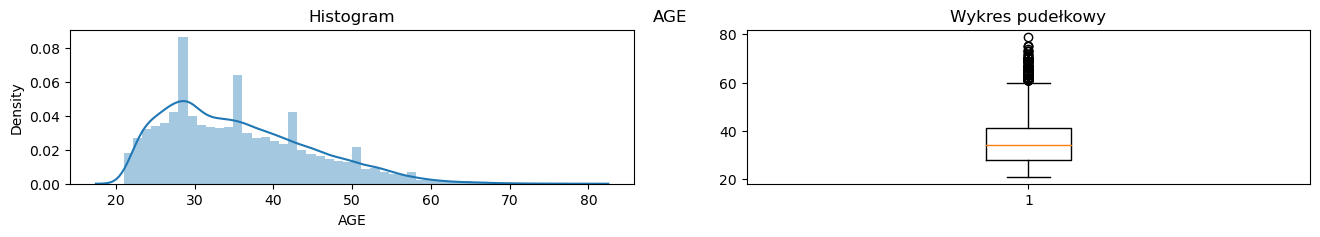

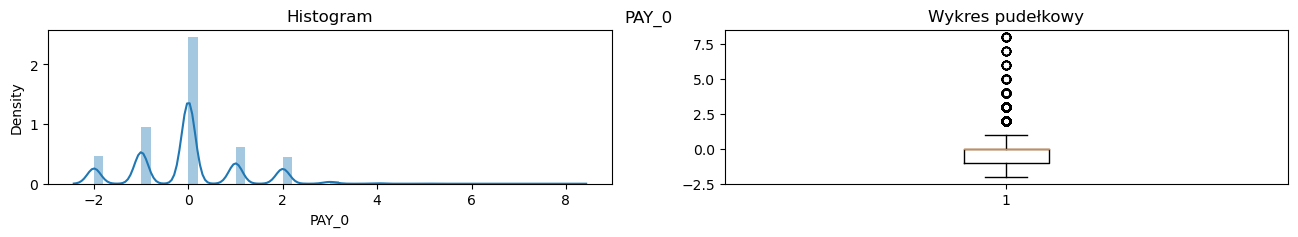

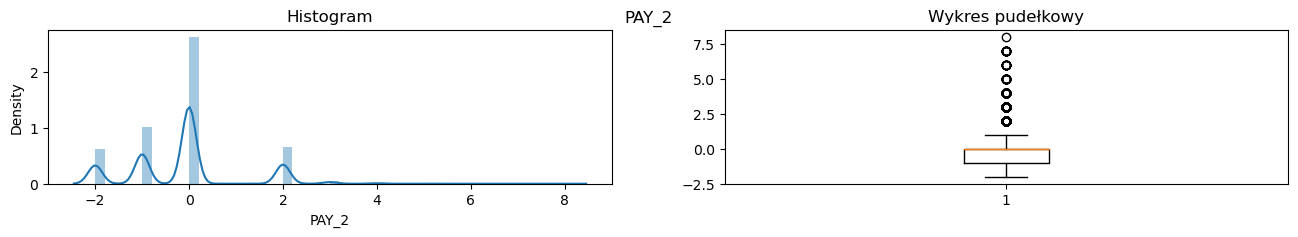

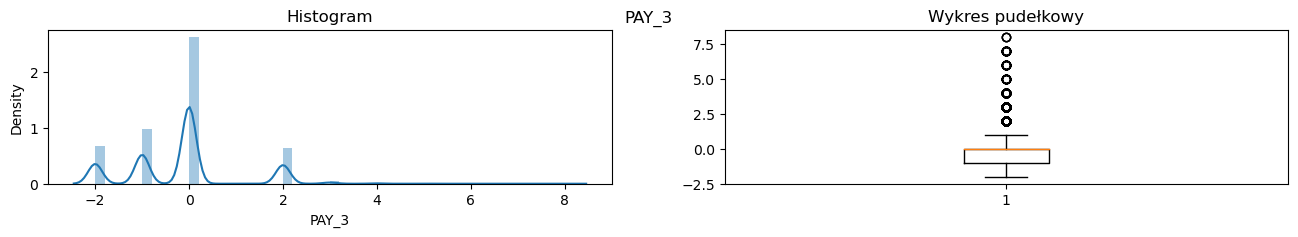

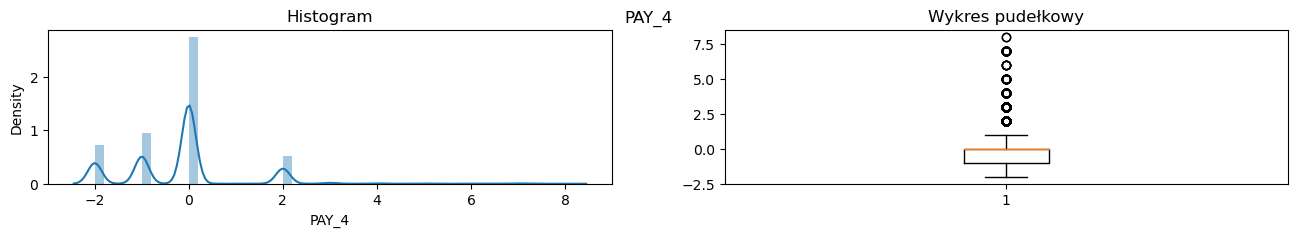

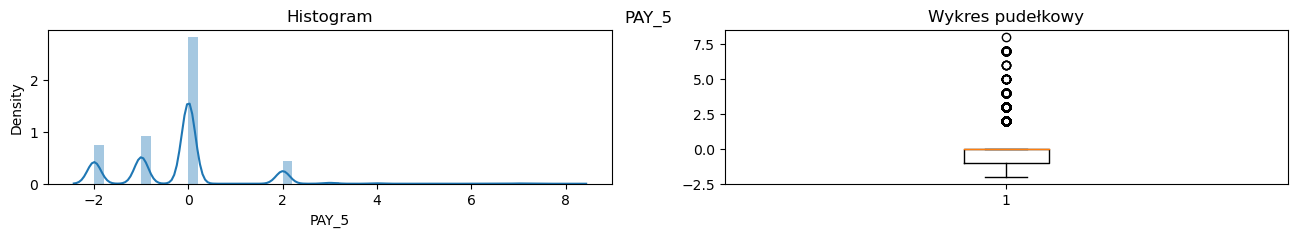

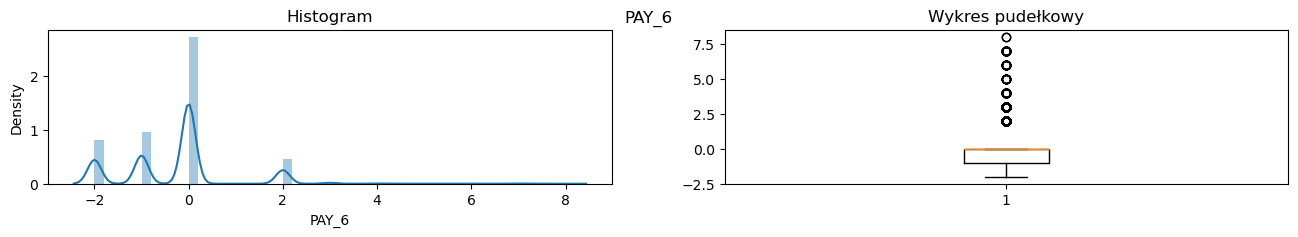

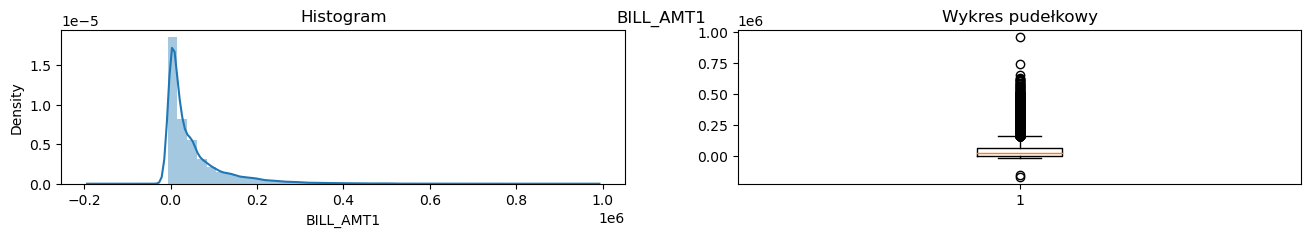

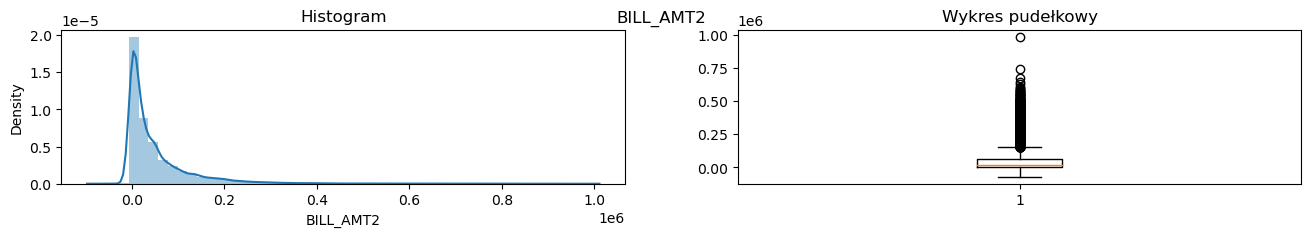

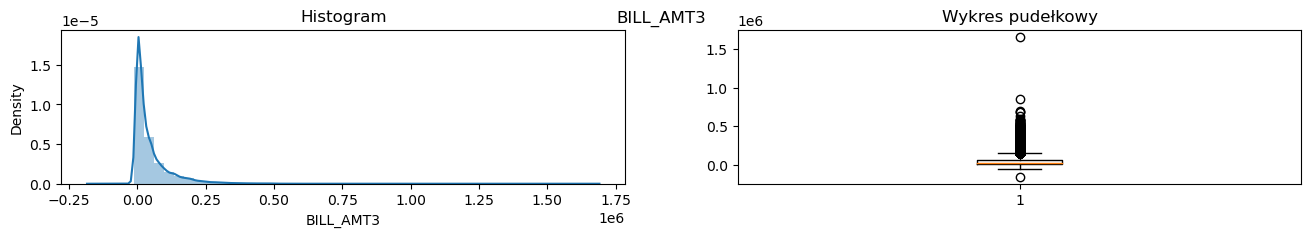

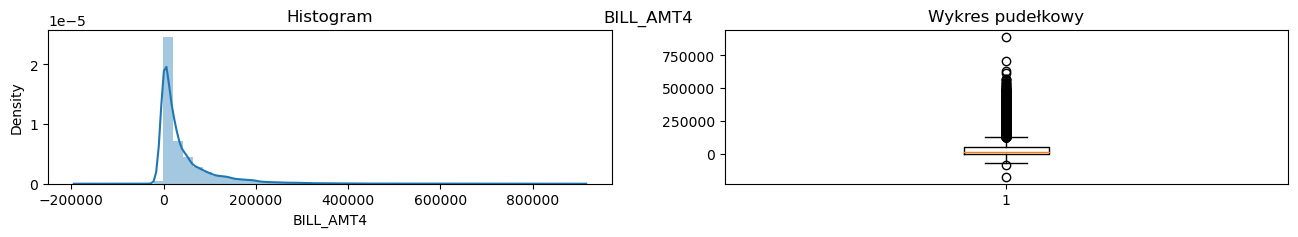

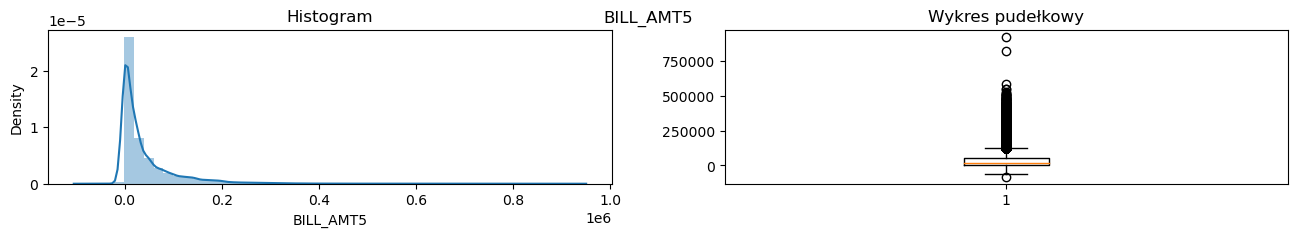

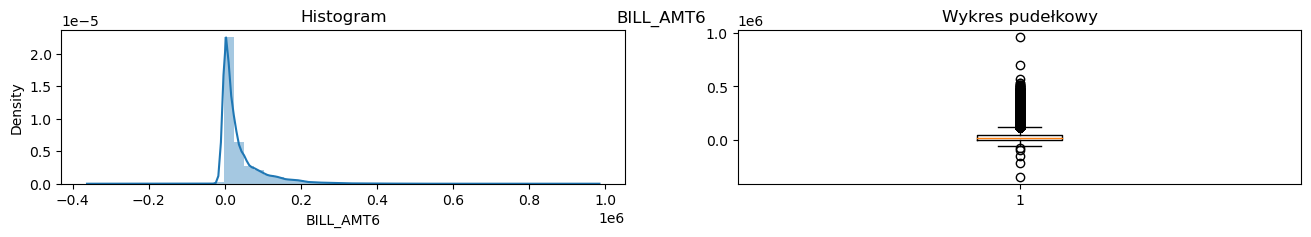

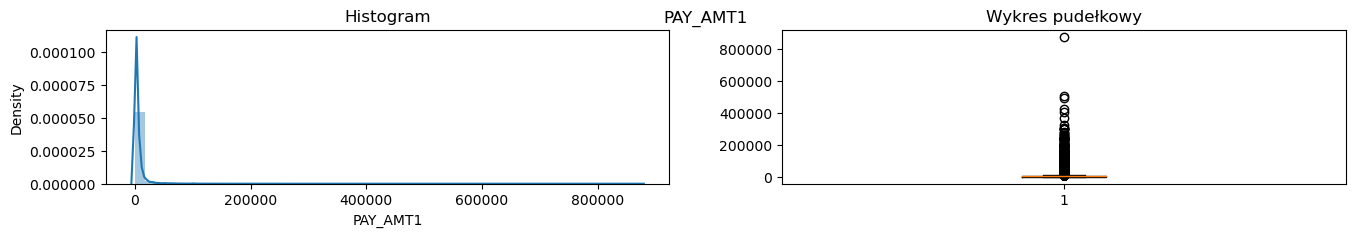

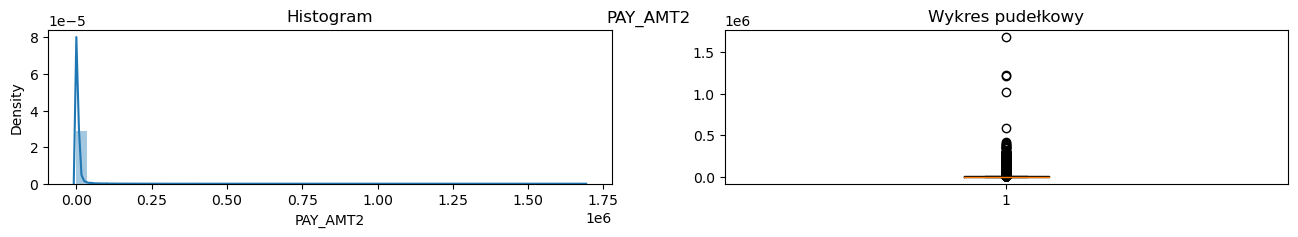

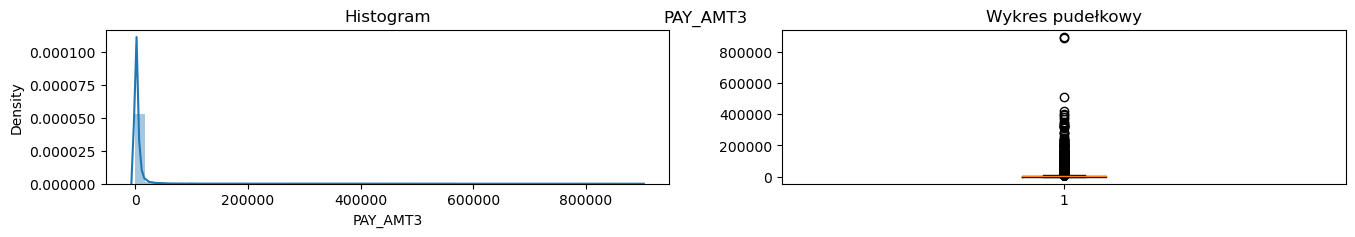

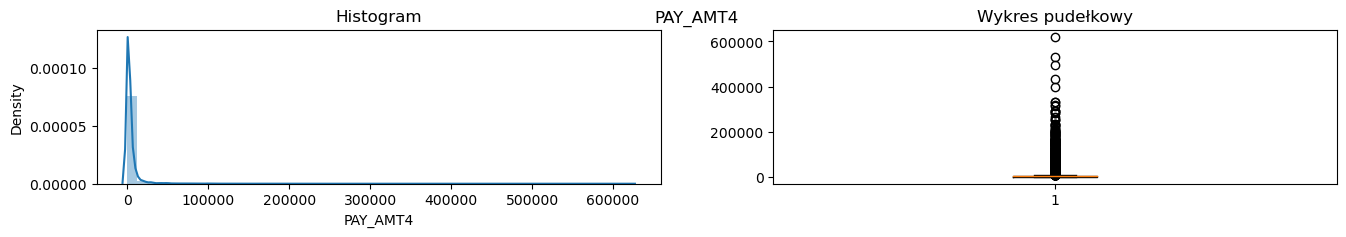

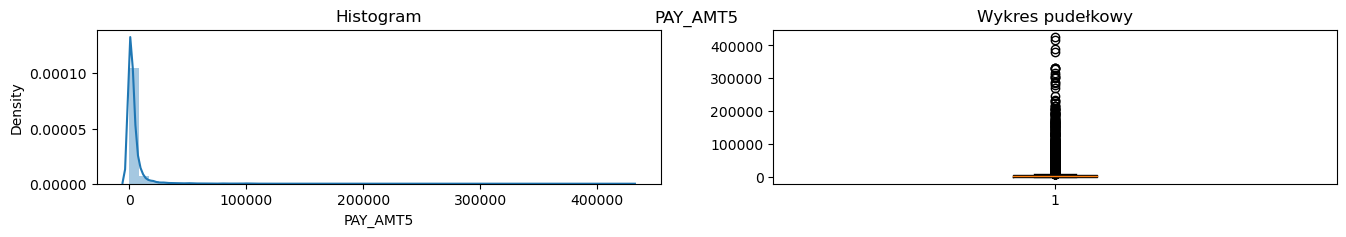

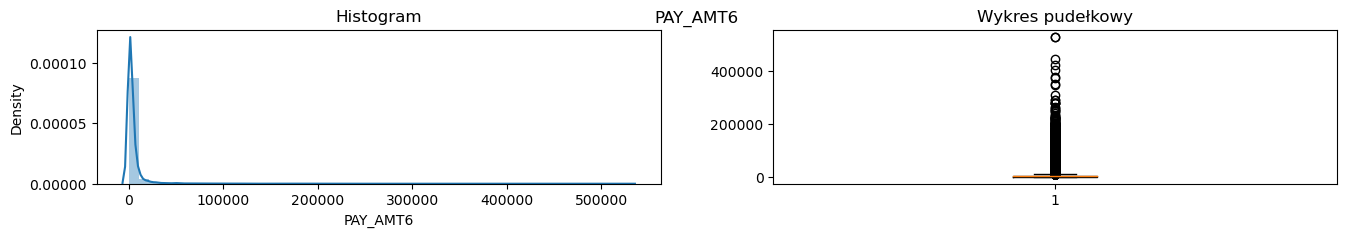

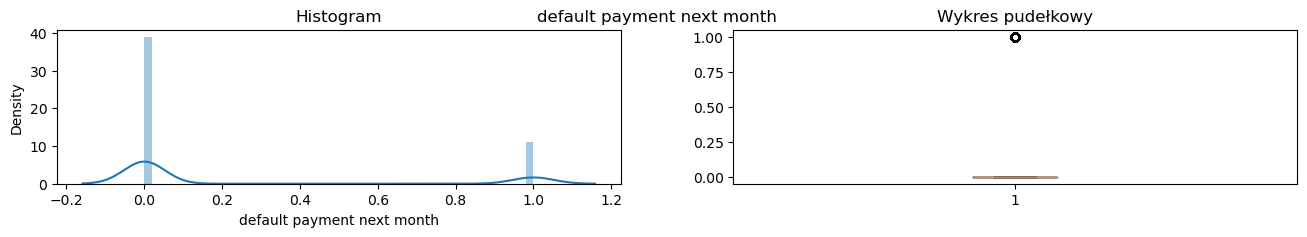

In [7]:
for variable in data.select_dtypes(include=np.number).columns:
    fig = plt.figure(figsize=(16, 2))
    fig.suptitle(variable, fontsize=12)
    plt.subplot(121)
    sns.distplot(data[variable], kde=True, rug=False)
    plt.title('Histogram')
    plt.subplot(122)
    plt.boxplot(data[variable])
    plt.title('Wykres pudełkowy')
    plt.show()

Z powyższych danych wynika że średnia wartość udzielanego kretytu to blisko 170 000 dolarów. Większość klientów stanowią niezamężne kobiety w wieku 35 lat posiadające wykształcenie wyższe. W większości dokunją spłąt zobowiązań w terminie. Średnia wysokość miesięcznej spłaty to 5 000 dolarów, a ich saldo rachunku pozostaje dodatnie. W powyższej analizie przeważąją przypadki negatywnej decyzji o przyznaniu karty kredytowej.

Podział na zmienne objaśniające X i y

In [8]:
X = data[data.columns[:-1]]
y = data['default payment next month']

In [9]:
pd.Series(y).value_counts(normalize=True)

0    0.778742
1    0.221258
Name: default payment next month, dtype: float64

Rozkład danych

In [10]:
X.describe()

LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    29965.000000  29965.000000  29965.000000  29965.000000  29965.000000   
mean    167442.005006      1.603738      1.853629      1.551877     35.487969   
std     129760.135222      0.489128      0.790411      0.521997      9.219459   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  29965.000000  29965.000000  29965.000000  29965.000000  29965.000000   
mean      -0.016753     -0.131854     -0.164392     -0.218922     -0.264509   
std        1.123492      1.196322      1.195878      1.168175      1.132220   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

       ...     BILL_AMT3      BILL_AMT4      BILL_AMT5      BILL_AMT6  \
count  ...  2.996500e+04   29965.000000   29965.000000   29965.000000   
mean   ...  4.706792e+04   43313.329885   40358.334390   38917.012281   
std    ...  6.937135e+04   64353.514373   60817.130623   59574.147742   
min    ... -1.572640e+05 -170000.000000  -81334.000000 -339603.000000   
25%    ...  2.711000e+03    2360.000000    1787.000000    1262.000000   
50%    ...  2.013500e+04   19081.000000   18130.000000   17124.000000   
75%    ...  6.020100e+04   54601.000000   50247.000000   49252.000000   
max    ...  1.664089e+06  891586.000000  927171.000000  961664.000000   

            PAY_AMT1      PAY_AMT2       PAY_AMT3       PAY_AMT4  \
count   29965.000000  2.996500e+04   29965.000000   29965.000000   
mean     5670.099316  5.927983e+03    5231.688837    4831.617454   
std     16571.849467  2.305346e+04   17616.361124   15674.464538   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%      1000.000000  8.500000e+02     390.000000     300.000000   
50%      2102.000000  2.010000e+03    1804.000000    1500.000000   
75%      5008.000000  5.000000e+03    4512.000000    4016.000000   
max    873552.000000  1.684259e+06  896040.000000  621000.000000   

            PAY_AMT5       PAY_AMT6  
count   29965.000000   29965.000000  
mean     4804.897047    5221.498014  
std     15286.372298   17786.976864  
min         0.000000       0.000000  
25%       261.000000     131.000000  
50%      1500.000000    1500.000000  
75%      4042.000000    4000.000000  
max    426529.000000  528666.000000  

[8 rows x 23 columns]

Porównanie zmiennych numerycznych X do zmiennej kategorycznej y z wykorzystaniem histogramów.

In [11]:
data['average_BILL'] = data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
data['average_PAY'] = data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
data.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0     -2  ...          0         0       689         0         0         0   
1      0  ...       3261         0      1000      1000      1000         0   
2      0  ...      15549      1518      1500      1000      1000      1000   
3      0  ...      29547      2000      2019      1200      1100      1069   
4      0  ...      19131      2000     36681     10000      9000       689   

   PAY_AMT6  default payment next month  average_BILL  average_PAY  
0         0                           1   1284.000000   114.833333  
1      2000                           1   2846.166667   833.333333  
2      5000                           0  16942.166667  1836.333333  
3      1000                           0  38555.666667  1398.000000  
4       679                           0  18223.166667  9841.500000  

[5 rows x 26 columns]

In [12]:
features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'average_BILL', 'average_PAY']
target = 'default payment next month'

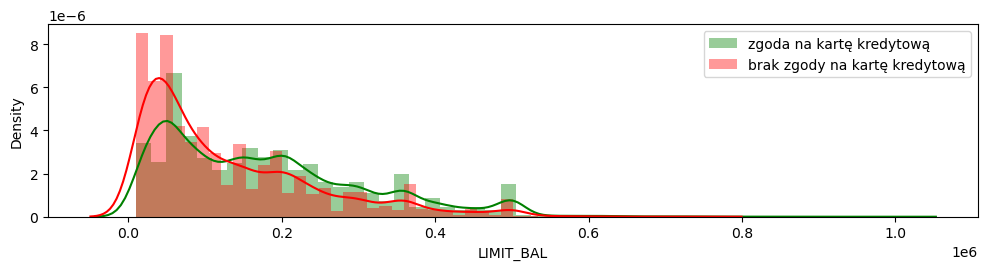

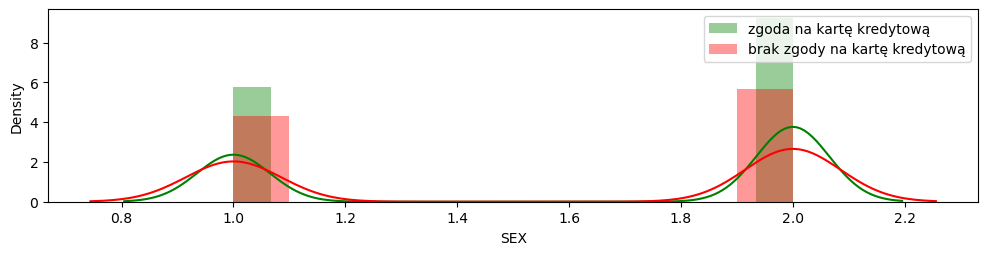

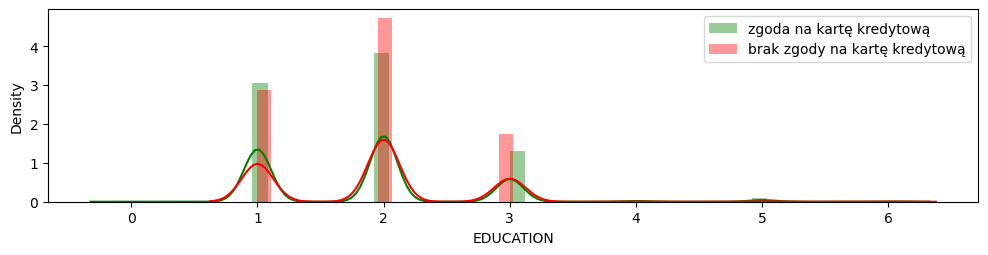

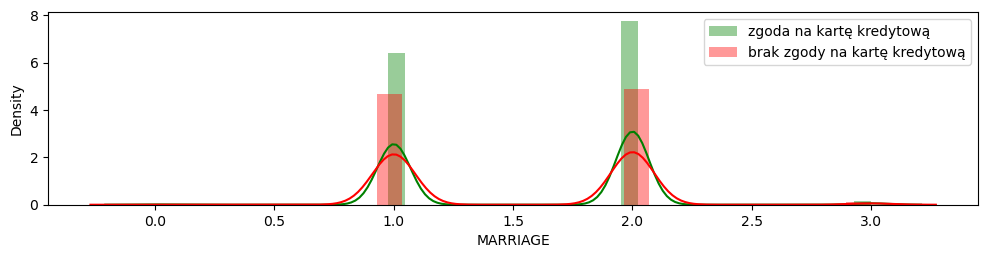

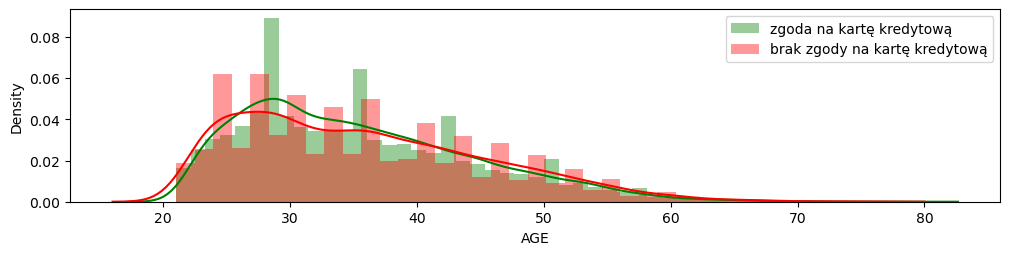

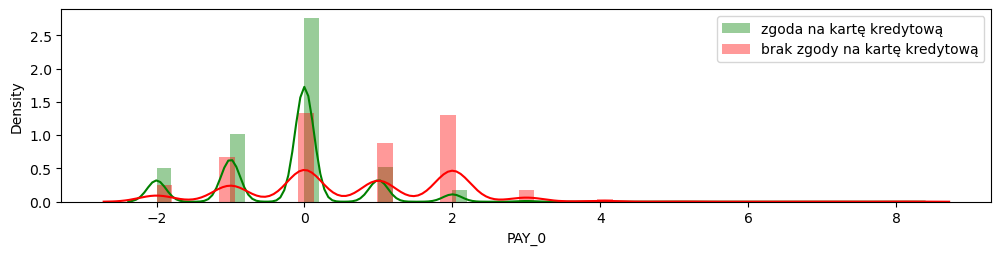

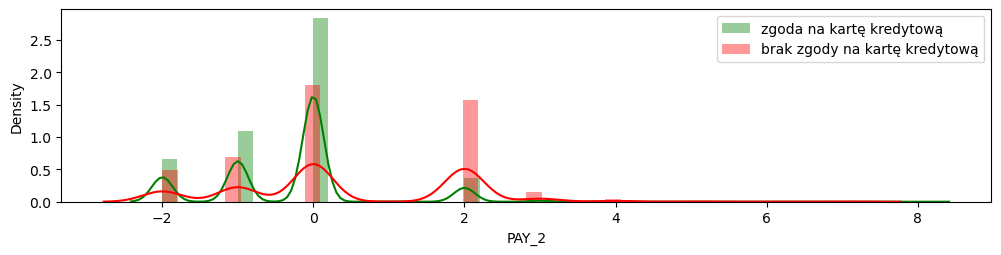

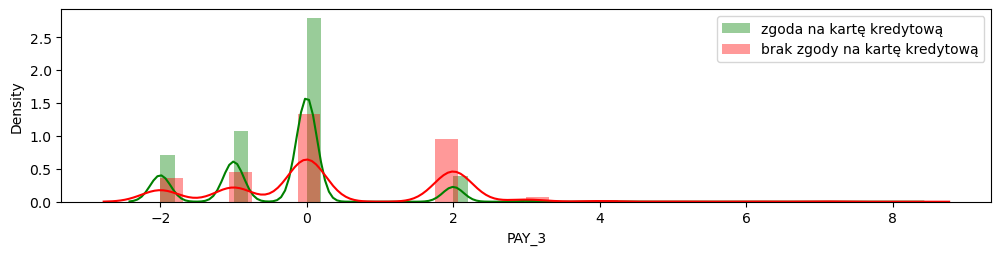

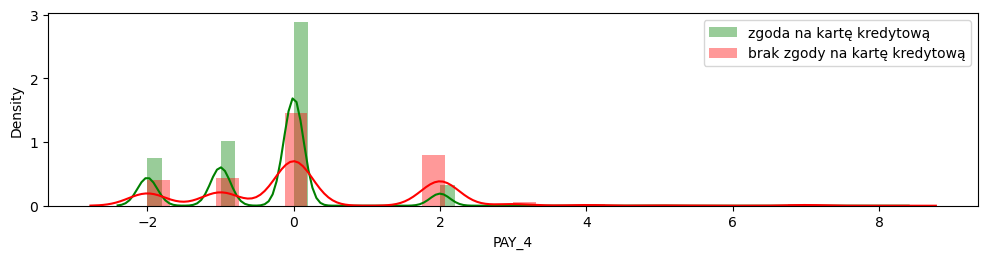

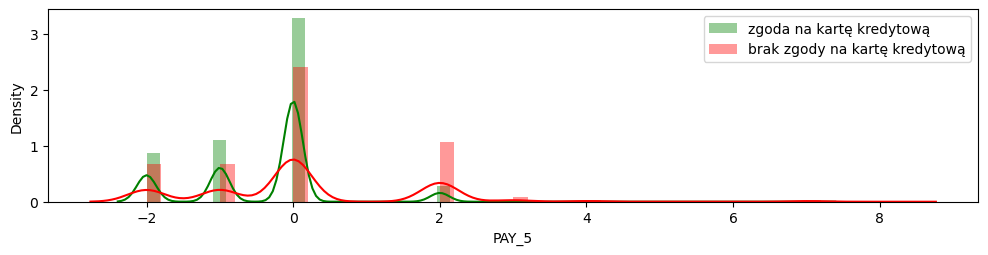

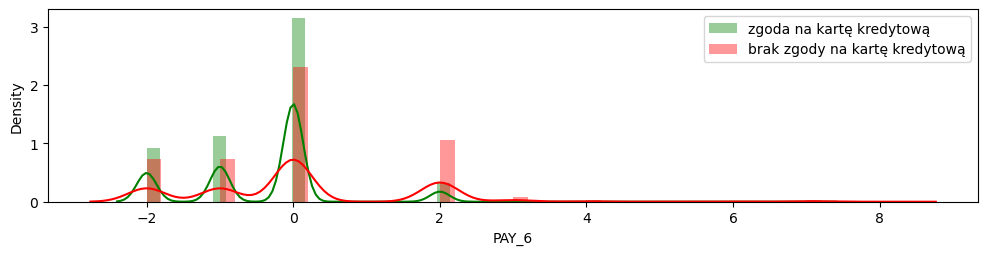

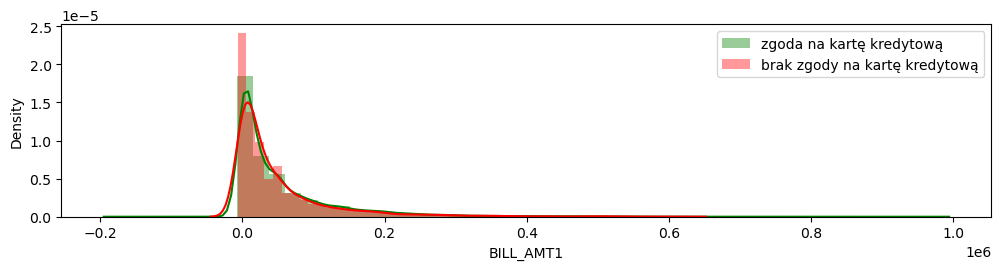

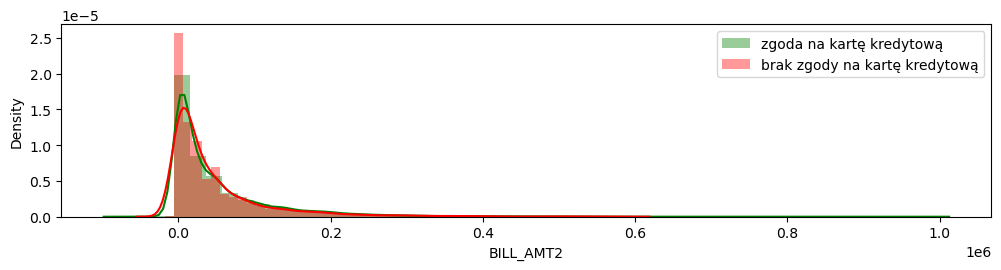

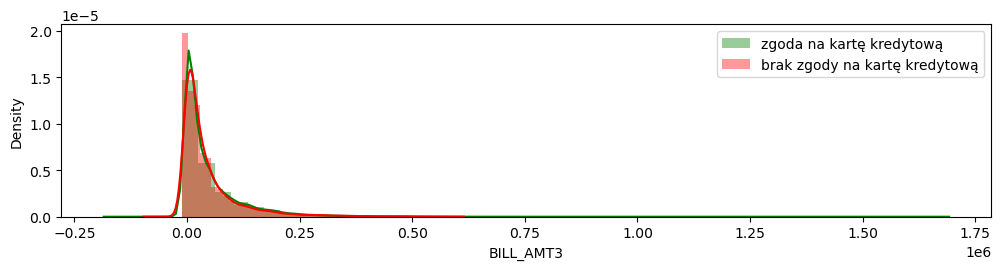

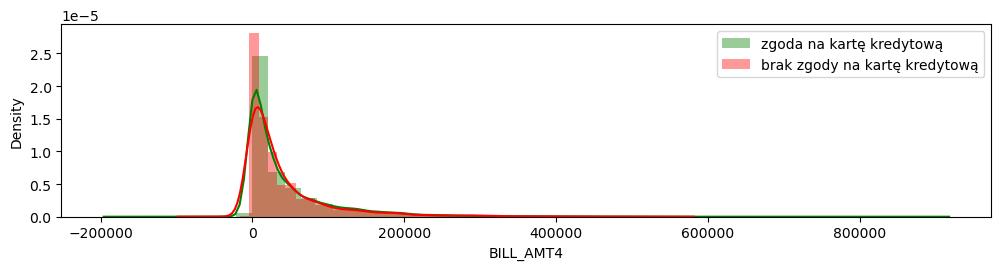

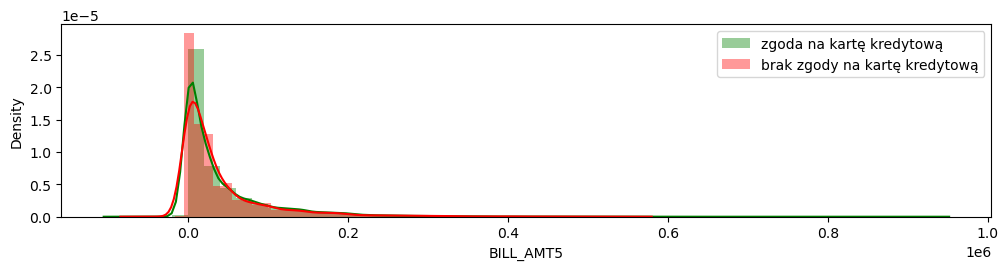

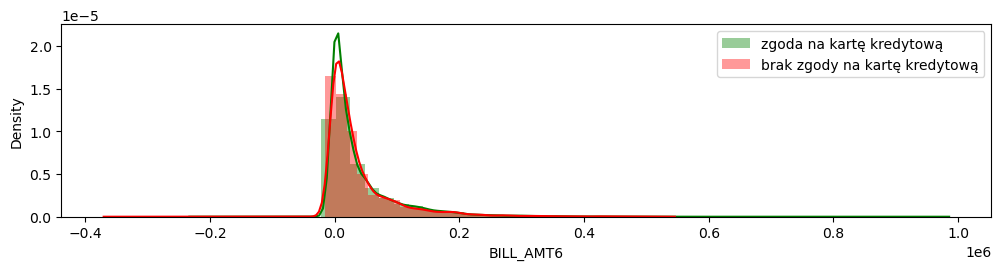

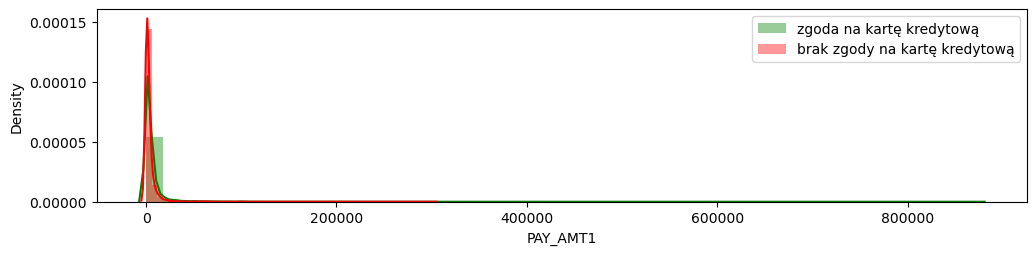

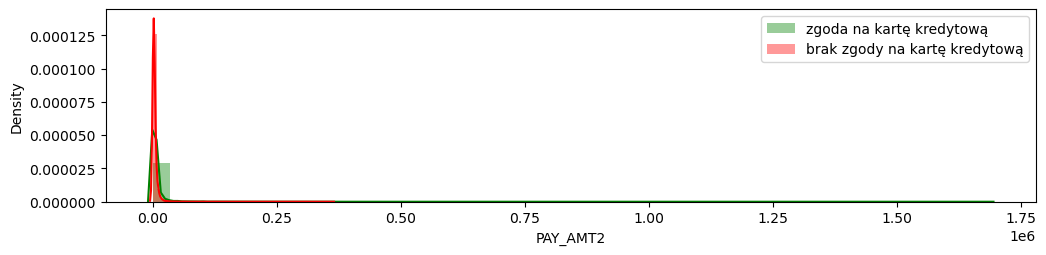

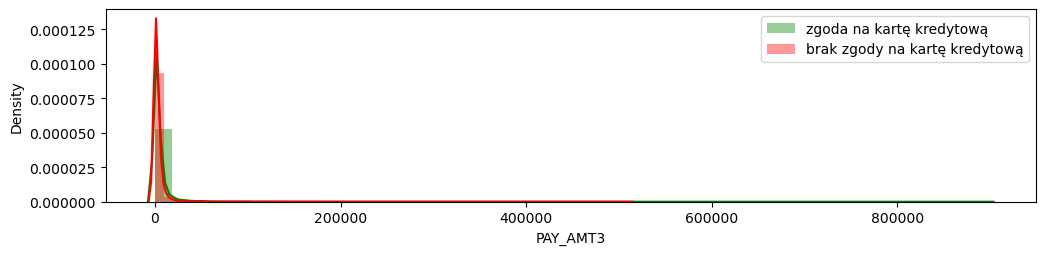

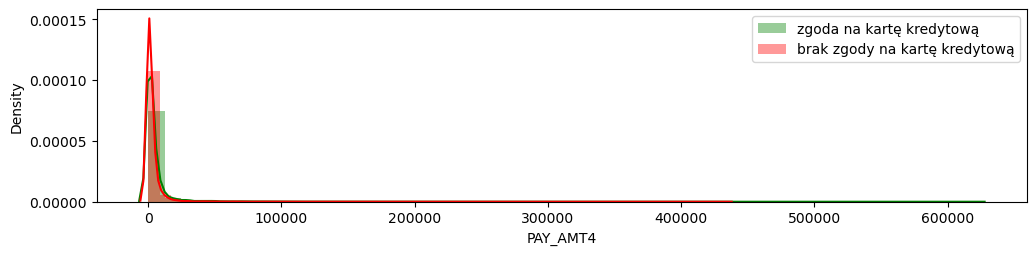

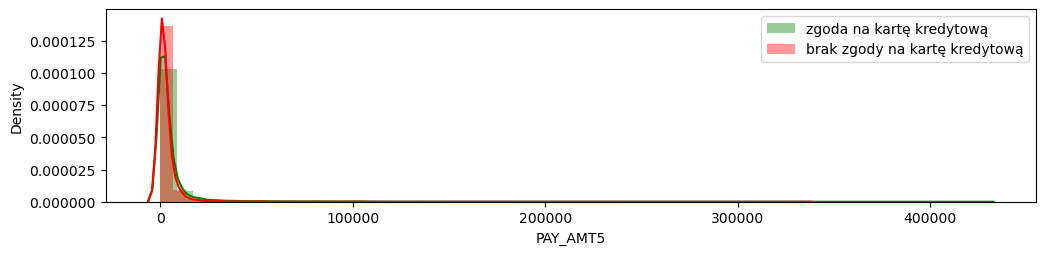

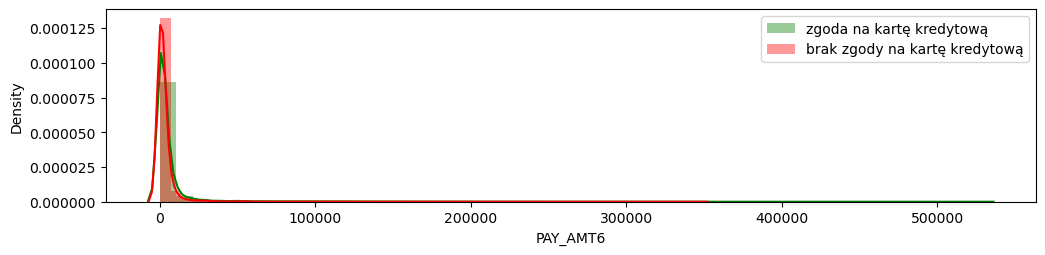

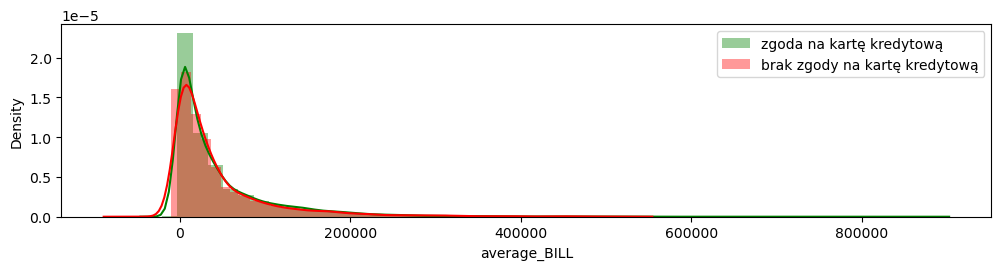

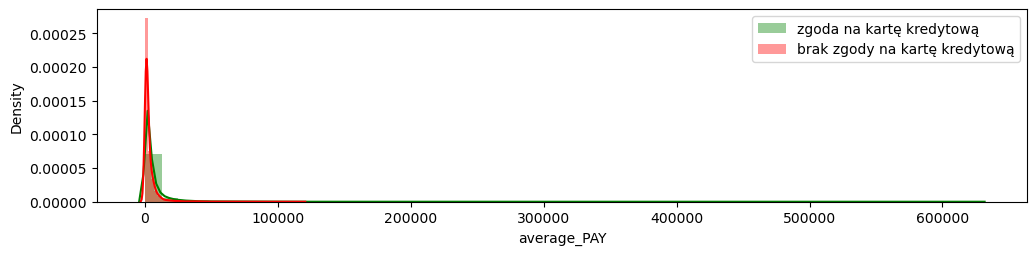

In [13]:
for col in features:
    plt.figure(figsize=(12, 2.5))
    sns.distplot(data.loc[data['default payment next month']==0, col], kde=True, rug=False, color='green', label='zgoda na kartę kredytową')
    sns.distplot(data.loc[data['default payment next month']==1, col], kde=True, rug=False, color='red', label='brak zgody na kartę kredytową')
    plt.legend(loc='upper right')
    plt.show()

Porównanie zmiennych numerycznych X do zmiennej kategorycznej y z wykresów pudełkowych.

Unique values: 81


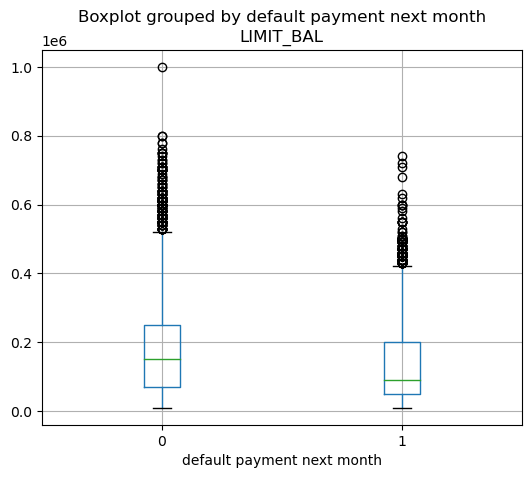

Unique values: 2


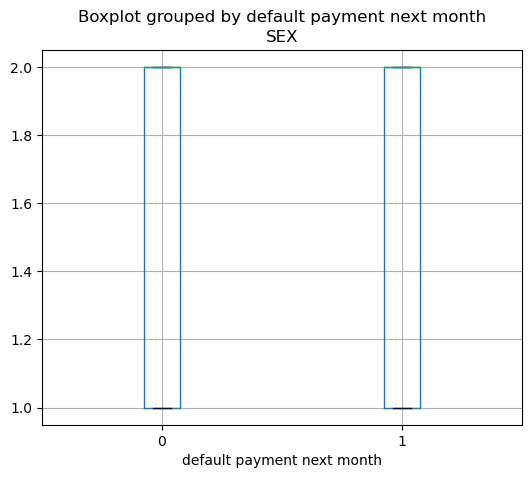

Unique values: 7


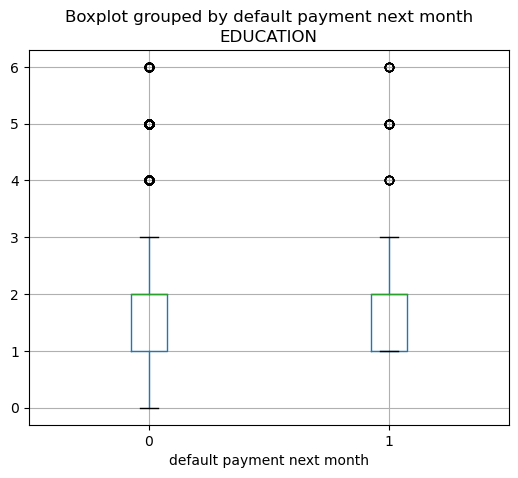

Unique values: 4


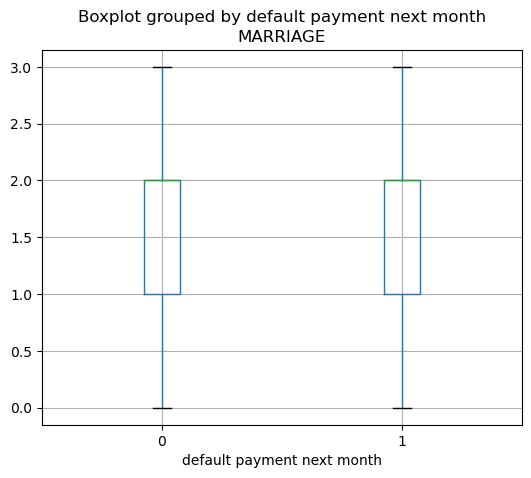

Unique values: 56


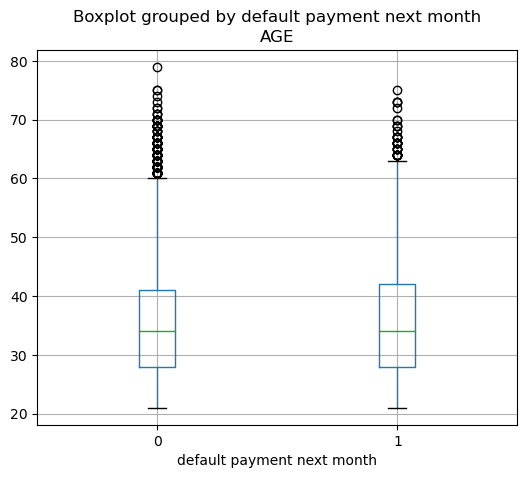

Unique values: 11


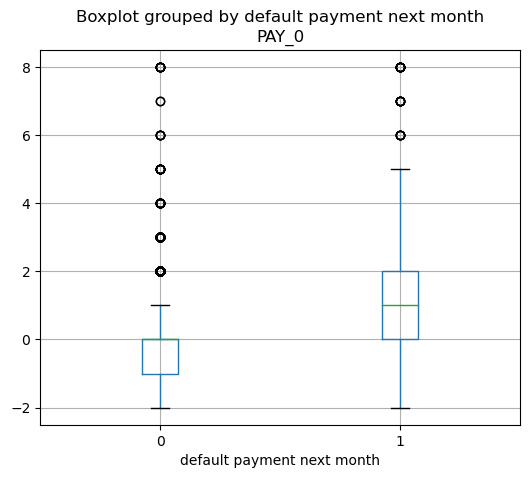

Unique values: 11


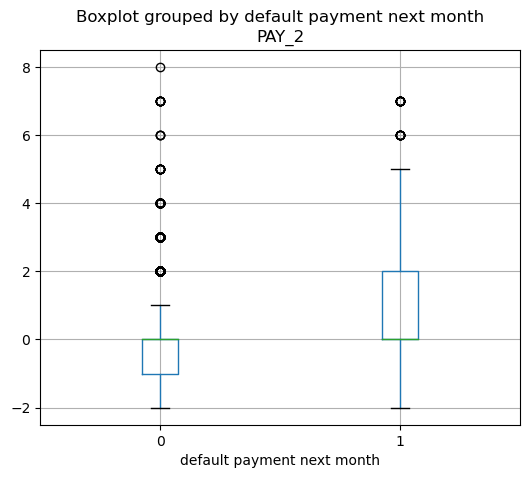

Unique values: 11


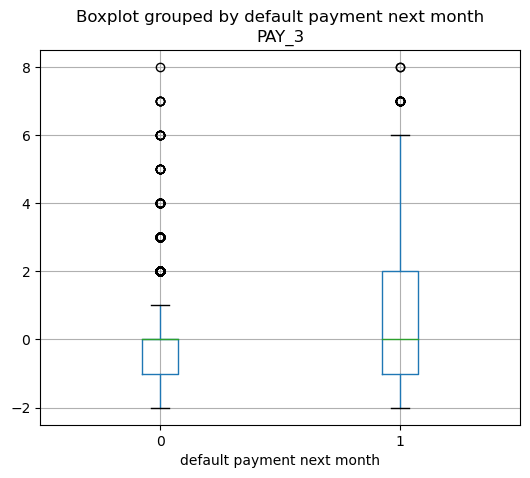

Unique values: 11


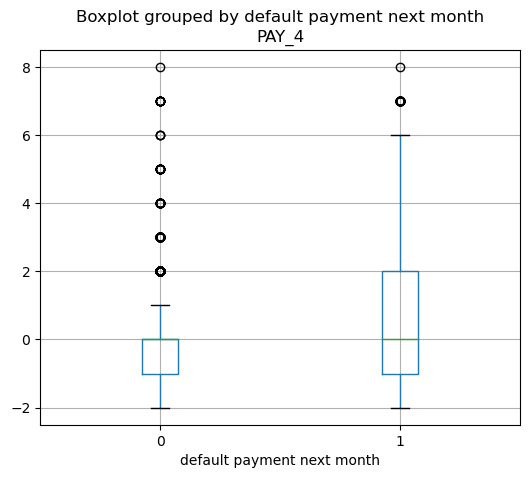

Unique values: 10


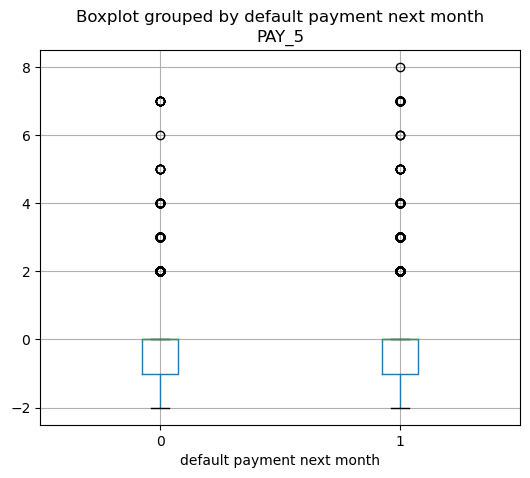

Unique values: 10


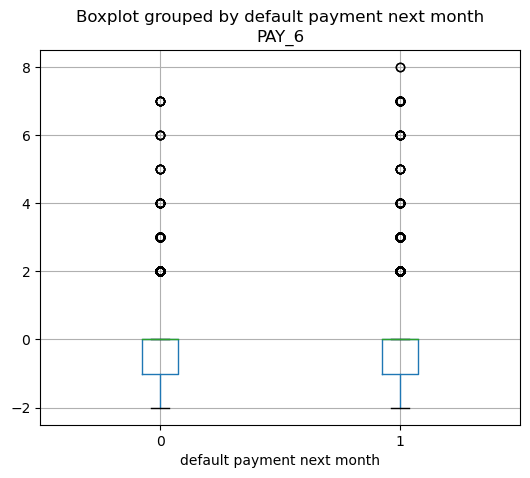

Unique values: 22723


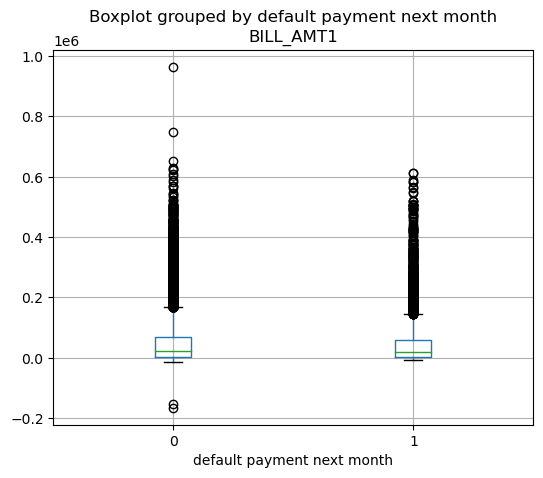

Unique values: 22346


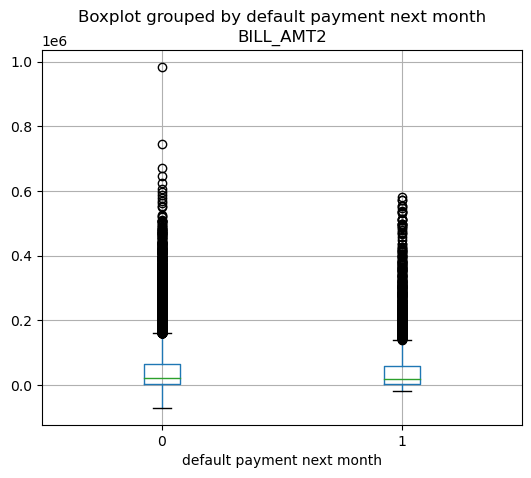

Unique values: 22026


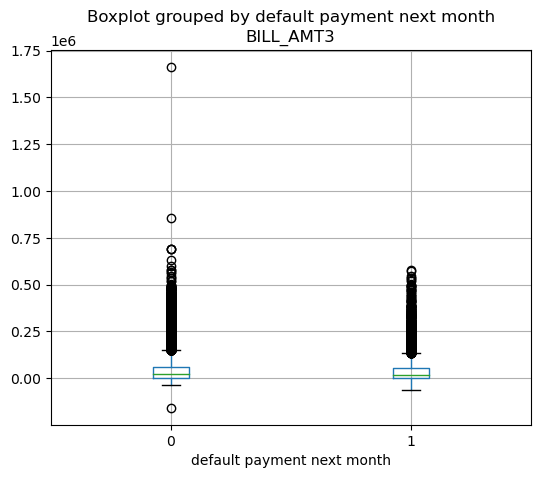

Unique values: 21548


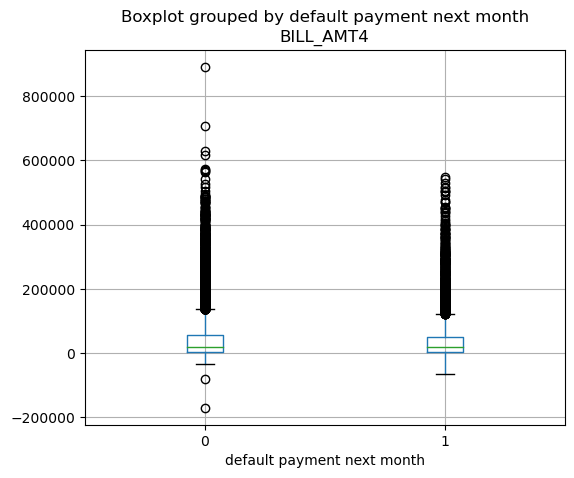

Unique values: 21010


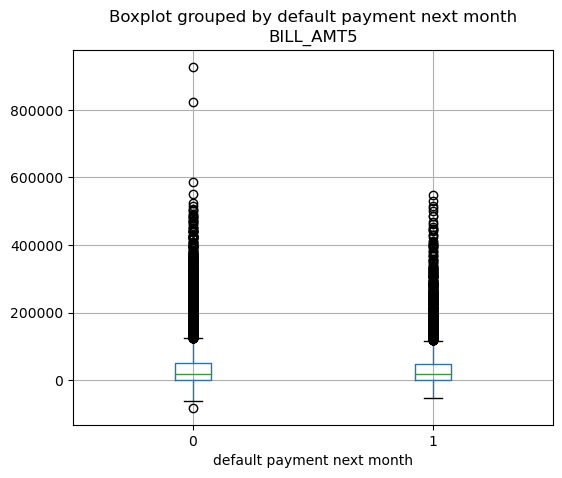

Unique values: 20604


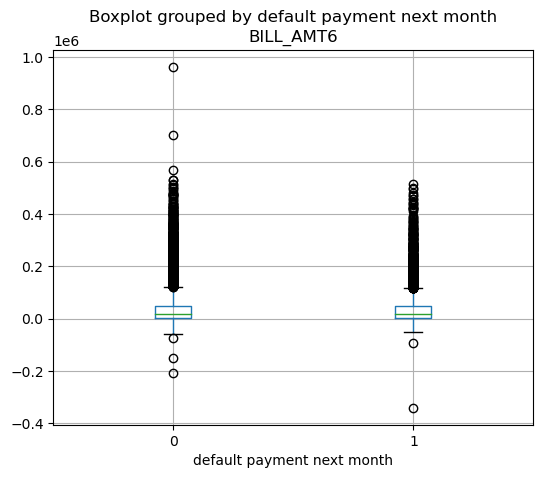

Unique values: 7943


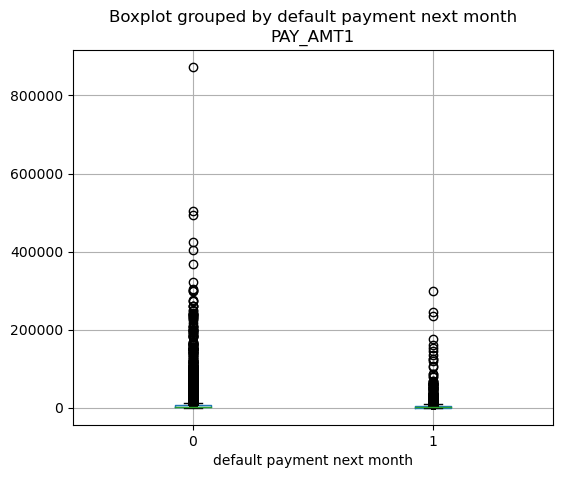

Unique values: 7899


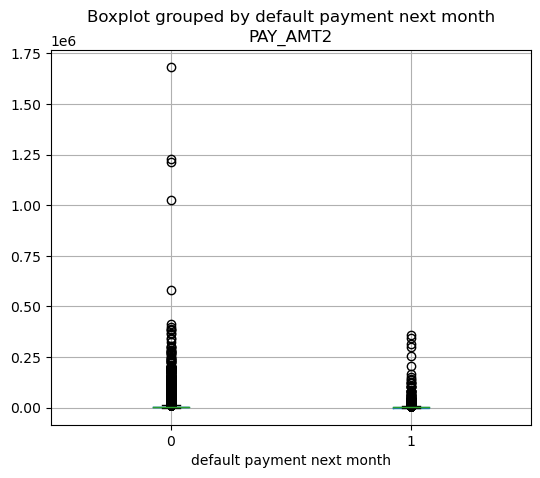

Unique values: 7518


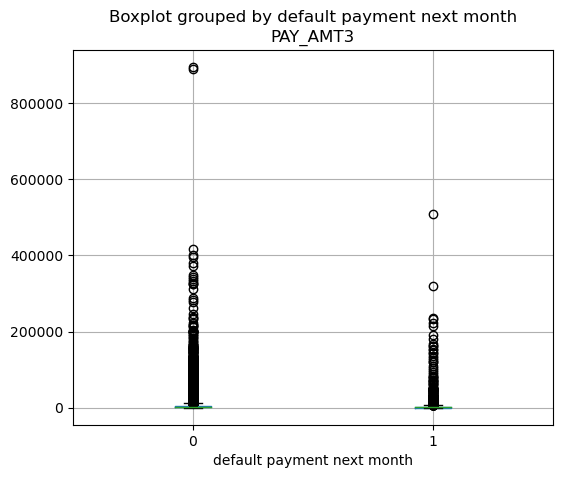

Unique values: 6937


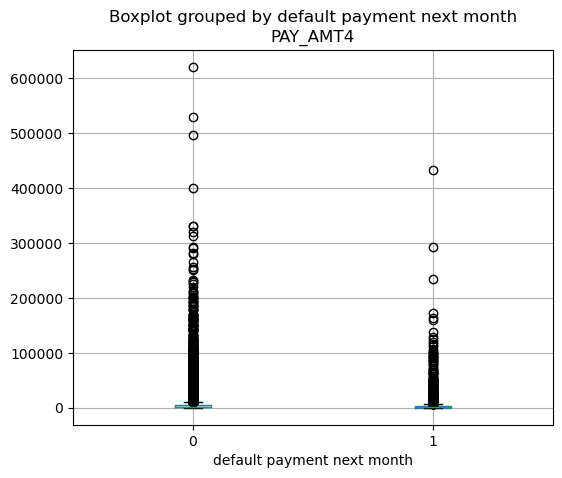

Unique values: 6897


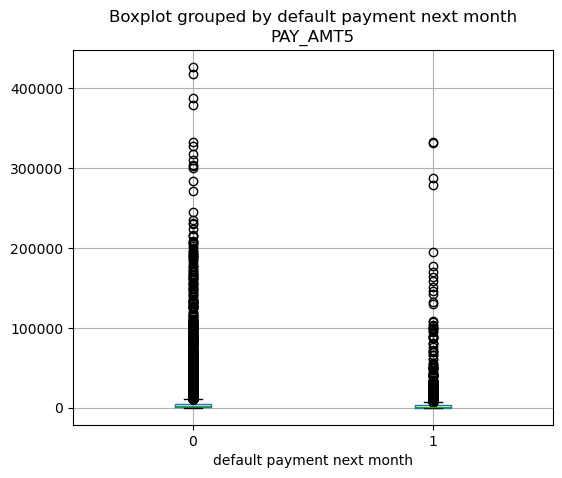

Unique values: 6939


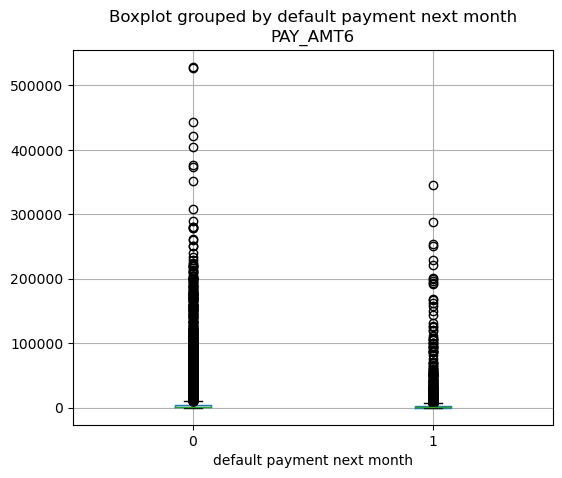

Unique values: 27370


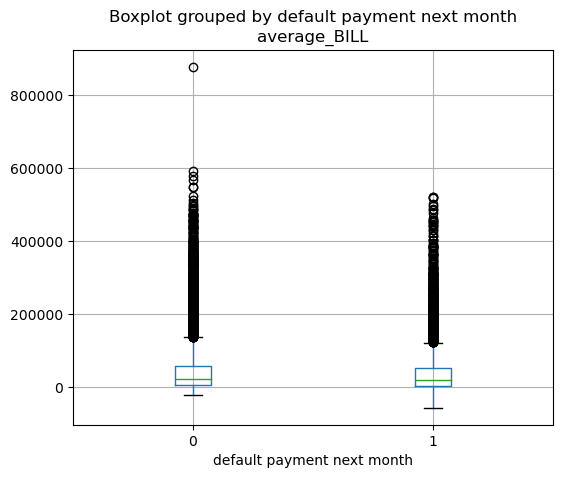

Unique values: 19180


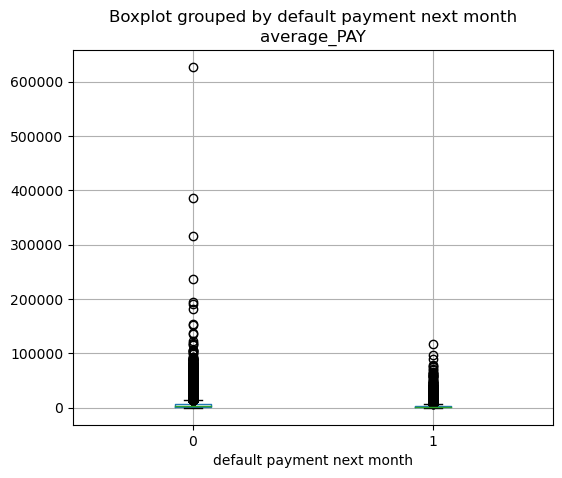

In [14]:
import matplotlib.pyplot as plt
for col in features:
    print(f'Unique values: {len(data[col].unique())}')
    data.boxplot(column=col, by='default payment next month', figsize=(6,5))
    plt.title(col)
    plt.show()

Z powyższych wizualizacji wynika brak wyraźnej zależności danych objaśniających X a daną objaśnianą y, czyli wydawaniem decyzji o przyznaniu karty kredytowej. Jednakże w przypadku zmiennych 'PAY_0', .... 'PAY_6' zarysowuje się korelacja.

Współczynnik korelacji punktowo-dwuseryjnej (Point-biserial correlation coefficient)

Podział danych na zbiór treningowy i testowy

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)
print ('Treningowe obserwacje: %d\nTestowe obserwacje: %d' % (X_train.shape[0], X_test.shape[0]))

Treningowe obserwacje: 20975
Testowe obserwacje: 8990


In [16]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelowanie i ewaluacja

# 1. Logistic Regression

In [17]:
modellr = LogisticRegression(multi_class='auto', random_state=25, n_jobs=-1)

modellr.fit(X_train,y_train)

LogisticRegression(n_jobs=-1, random_state=25)

Prognoza na zbiorze testowym z wykorzystaniem modelu regresji logistycznej.


In [18]:
lr_pred = modellr.predict(X_test)

modellr_cv = cross_val_score(modellr, X_train, y_train, cv=10).mean()

Metryki dla Logistic Regression:

In [19]:
print('Accuracy: %.3f' % modellr.score(X_test, y_test))
print('Cross-validation accuracy: %0.3f' % modellr_cv)
print('Precision: %.3f' % precision_score(y_test, lr_pred))
print('Recall: %.3f' % recall_score(y_test, lr_pred))
print('F1 score: %.3f' % f1_score(y_test, lr_pred))

Accuracy: 0.811
Cross-validation accuracy: 0.811
Precision: 0.729
Recall: 0.235
F1 score: 0.356


Przewidywanie prawdopodobieństw dla danych testowych

In [20]:
modellr_probs = modellr.predict_proba(X_test)

modellr_probs = modellr_probs[:, 1]

auc_modellr = roc_auc_score(y_test, modellr_probs)
print('AUC: %.2f' % auc_modellr)

AUC: 0.72


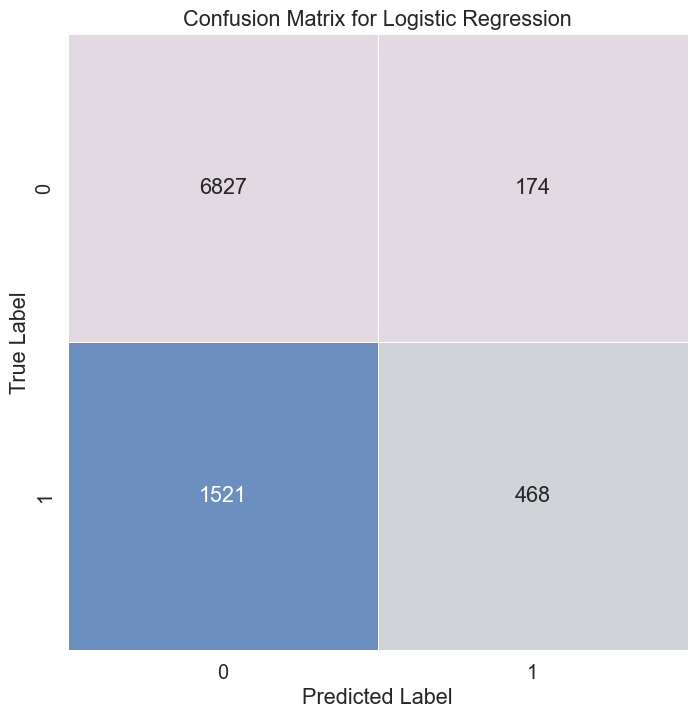

In [21]:
modellr_matrix = confusion_matrix(y_test,lr_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(modellr_matrix, annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Logistic Regression');

# 2.Grid search dla Logistic Regression

In [22]:
parameters = {'C':[0.0001, 0.001, 0.01, 1, 0.1, 10, 100, 1000], 'penalty':['none','l2'] ,
              'solver':['lbfgs','sag','saga','newton-cg']}

default_modellr=LogisticRegression(multi_class='auto', random_state=25, n_jobs=-1)

gs_modellr = GridSearchCV(default_modellr, parameters, cv=10, n_jobs=-1, verbose=1)

gs_modellr.fit(X_train,y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=25),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 1, 0.1, 10, 100, 1000],
                         'penalty': ['none', 'l2'],
                         'solver': ['lbfgs', 'sag', 'saga', 'newton-cg']},
             verbose=1)

In [23]:
gs_log_pred=gs_modellr.predict(X_test)

Metriki dla Grid Search LR

Przewidywanie prawdopodobieństw dla danych testowych

In [24]:
print("Best Logistic Regression Parameters: {}".format(gs_modellr.best_params_))
print('Cross-validation accuracy: %0.3f' % gs_modellr.best_score_)
print('Accuracy: %0.3f' % (gs_modellr.score(X_test,y_test)))
print('Precision: %.3f' % precision_score(y_test, gs_log_pred))
print('Recall: %.3f' % recall_score(y_test, gs_log_pred))
print('F1 score: %.3f' % f1_score(y_test, gs_log_pred))

Best Logistic Regression Parameters: {'C': 0.0001, 'penalty': 'none', 'solver': 'lbfgs'}
Cross-validation accuracy: 0.811
Accuracy: 0.812
Precision: 0.730
Recall: 0.236
F1 score: 0.357


Przewidywanie prawdopodobieństw dla danych testowych

In [25]:
gs_modellr_probs = gs_modellr.predict_proba(X_test)

gs_modellr_probs = gs_modellr_probs[:, 1]

gs_modellr_auc = roc_auc_score(y_test, gs_modellr_probs)
print('AUC: %.2f' % gs_modellr_auc)

AUC: 0.72


Porównanie prognozy z wartościami prawdziwymi za pomocą macierzy omyłek

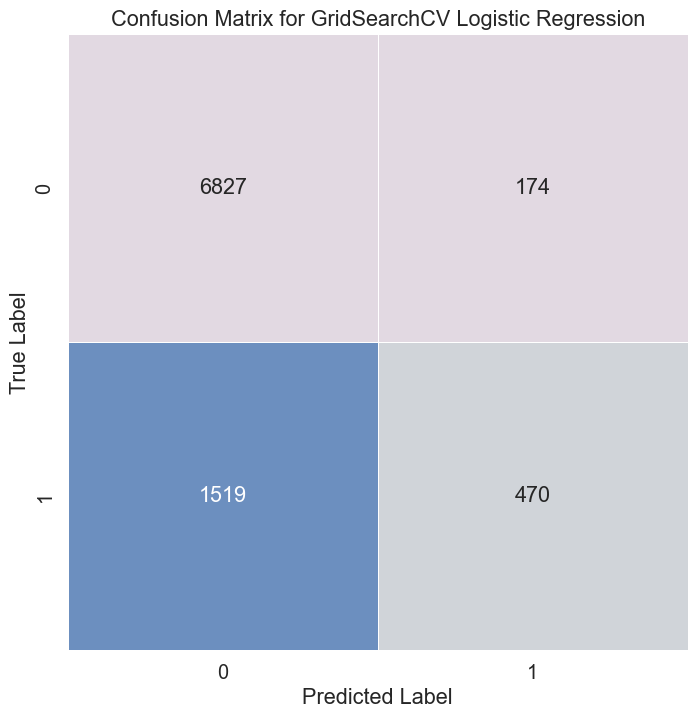

In [26]:
gs_modellr_matrix = confusion_matrix(y_test,gs_log_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(gs_modellr_matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for GridSearchCV Logistic Regression');

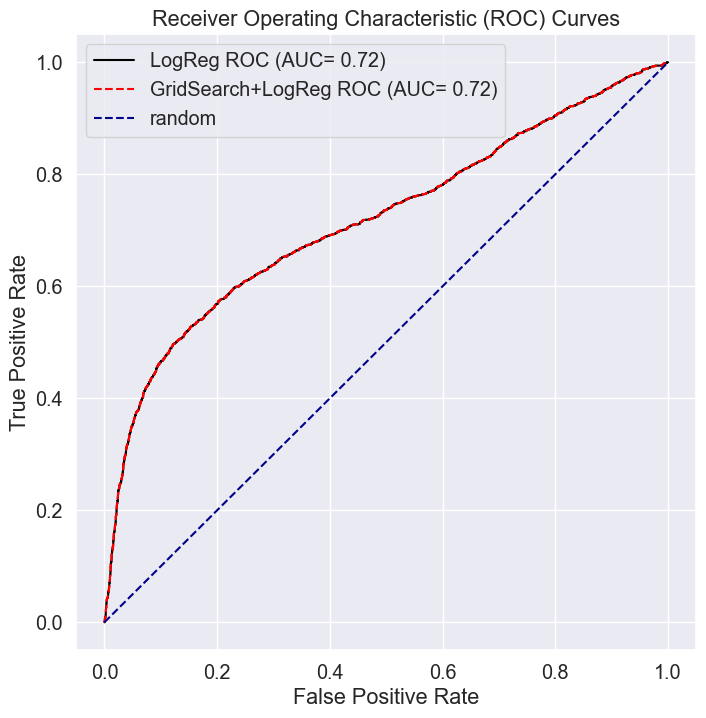

In [27]:
modellr_fpr, modellr_tpr, modellr_thresholds = roc_curve(y_test, modellr_probs)
gs_modellr_fpr, gs_modellr_tpr, gs_modellr_thresholds = roc_curve(y_test, gs_modellr_probs)

plt.figure(figsize=(8,8))
plt.plot(modellr_fpr, modellr_tpr, color='black', label='LogReg ROC (AUC= %0.2f)'% auc_modellr)
plt.plot(gs_modellr_fpr, gs_modellr_tpr, color='red', linestyle='--',label='GridSearch+LogReg ROC (AUC= %0.2f)'% gs_modellr_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

# 3. Decision tree

In [28]:
tr = tree.DecisionTreeClassifier(max_depth=3, criterion='gini', random_state=25)

tr.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=25)

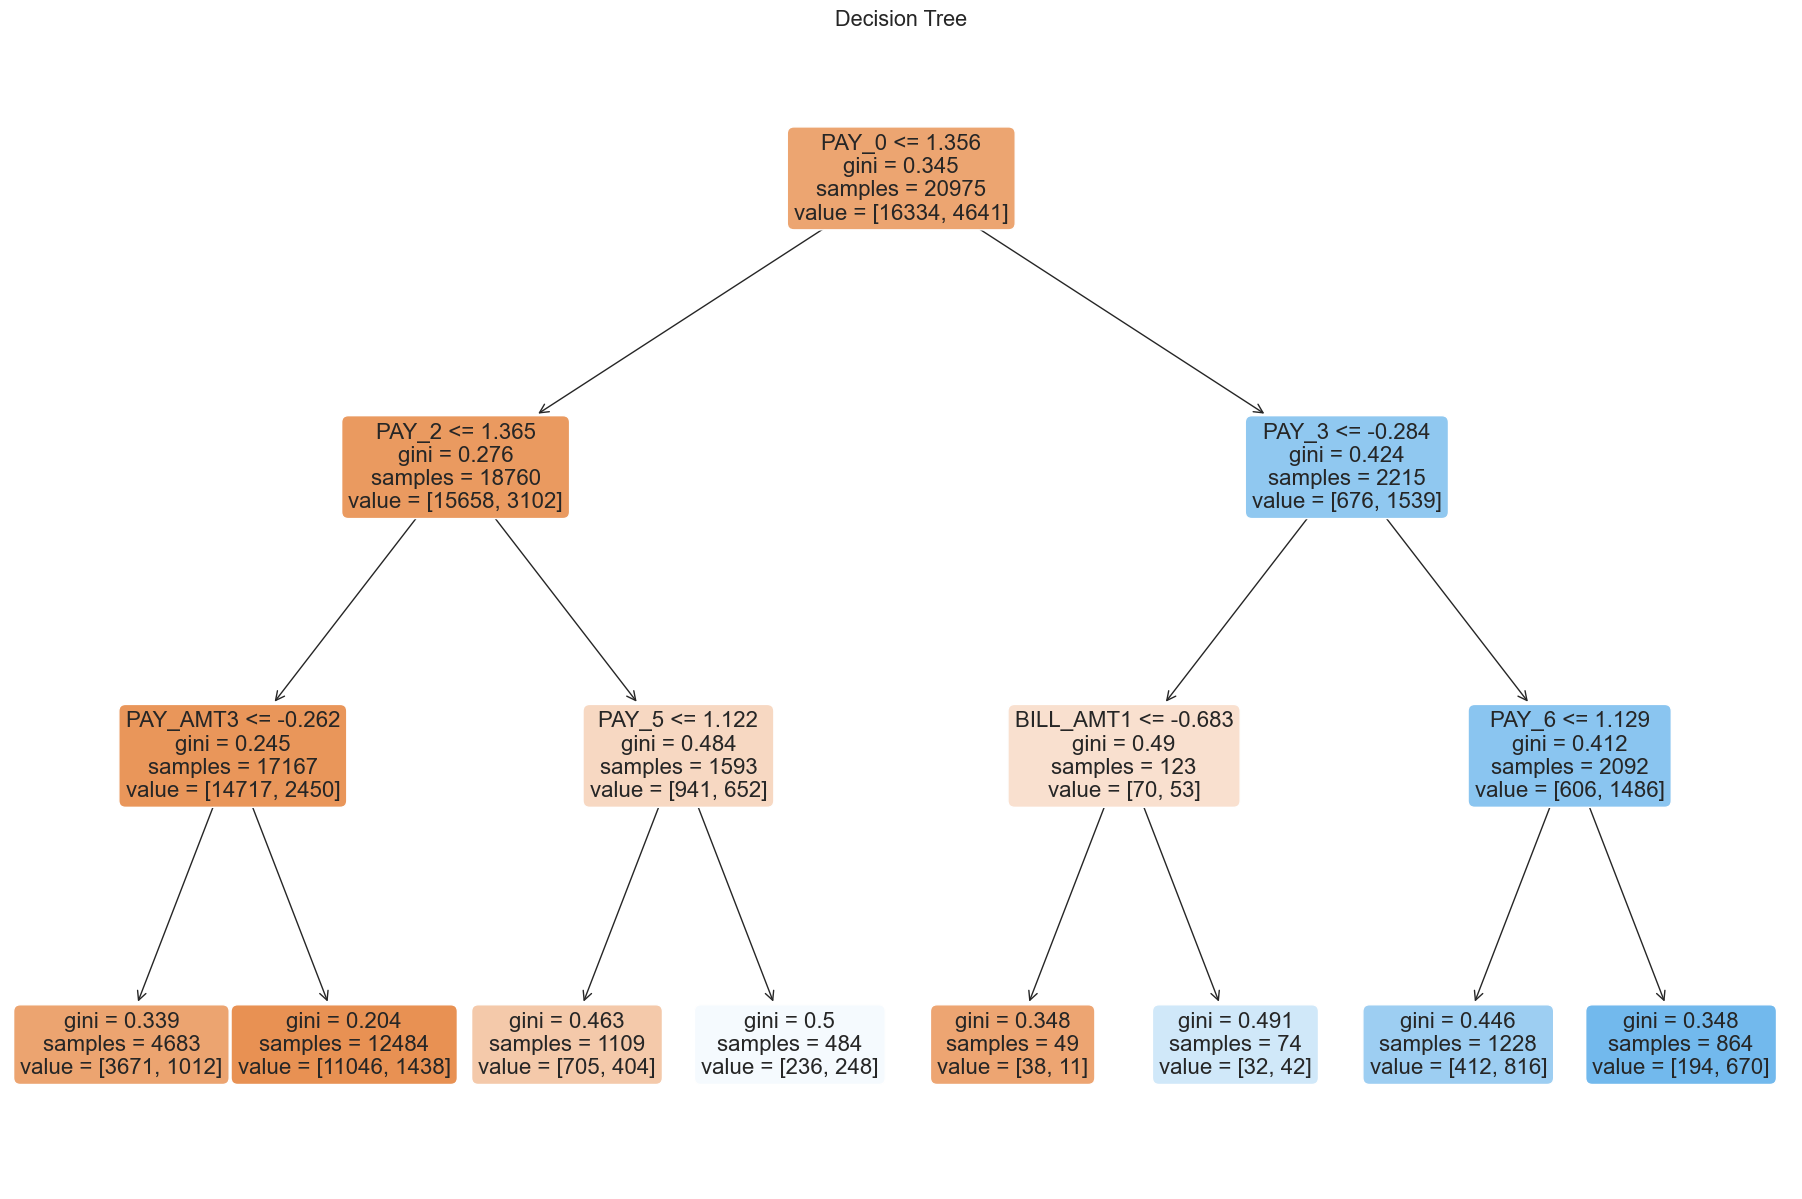

In [29]:
fig=plt.figure(figsize=(23,15))
tree.plot_tree(tr.fit(X_train, y_train),feature_names=X.columns,filled=True,rounded=True,fontsize=16);
plt.title('Decision Tree');

In [30]:
tr_pred=tr.predict(X_test)

tr_cv=cross_val_score(tr, X_train, y_train, cv=10).mean()

Metriki dla Decision Tree

In [31]:
print('Accuracy: %.3f' % tr.score(X_test, y_test))
print('Cross-validation accuracy: %0.3f' % tr_cv)
print('Precision: %.3f' % precision_score(y_test, tr_pred))
print('Precision: %.3f' % recall_score(y_test, tr_pred))
print('F1 score: %.3f' % f1_score(y_test, tr_pred))

Accuracy: 0.821
Cross-validation accuracy: 0.819
Precision: 0.673
Precision: 0.371
F1 score: 0.478


Porównanie prognozy z wartościami prawdziwymi za pomocą macierzy omyłek

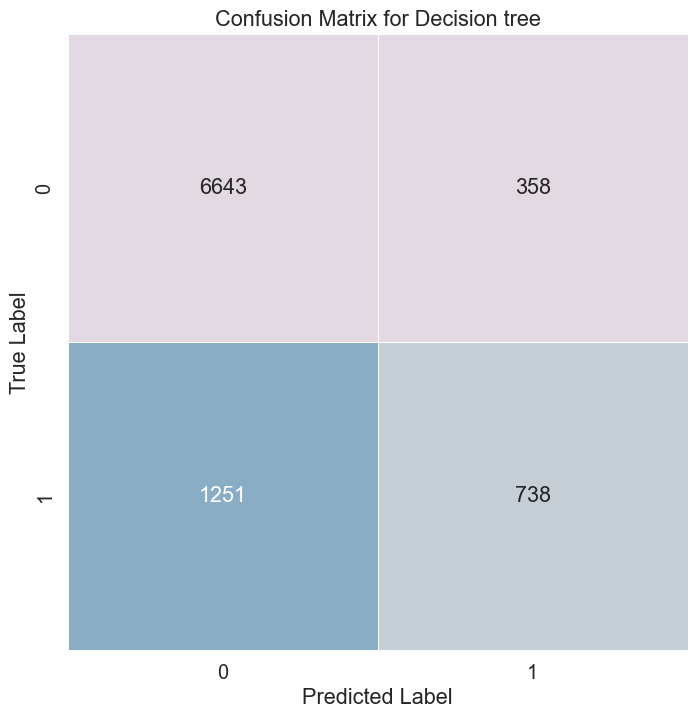

In [32]:
tr_matrix = confusion_matrix(y_test,tr_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(tr_matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Decision tree');

Przewidywanie prawdopodobieństw dla danych testowych

In [33]:
tr_probs = tr.predict_proba(X_test)

tr_probs = tr_probs[:, 1]

auc_tr = roc_auc_score(y_test, tr_probs)
print('AUC: %.2f' % auc_tr)

AUC: 0.73


# 4. Grid search dla Decision tree

Hiperparametry do sprawdzenia i trenowanie modelu

In [34]:
parameters = {'criterion':['gini','entropy'],
              'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
             }

default_tr = tree.DecisionTreeClassifier(random_state=25)

gs_tree = GridSearchCV(default_tr, parameters, cv=10, n_jobs=-1,verbose=1)

gs_tree.fit(X_train,y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=25),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             verbose=1)

Prognozowanie z najlepszymi parametrami

In [35]:
gs_tree_pred=gs_tree.predict(X_test)

Metriki dla Grid searcg DT

In [36]:
print("Best Decision tree Parameters: {}".format(gs_tree.best_params_))
print('Cross-validation accuracy: %0.3f' % gs_tree.best_score_)
print('Accuracy: %0.3f' % (gs_tree.score(X_test,y_test)))
print('Precision: %.3f' % precision_score(y_test, gs_tree_pred))
print('Recall: %.3f' % recall_score(y_test, gs_tree_pred))
print('F1 score: %.3f' % f1_score(y_test, gs_tree_pred))

Best Decision tree Parameters: {'criterion': 'gini', 'max_depth': 4}
Cross-validation accuracy: 0.821
Accuracy: 0.821
Precision: 0.684
Recall: 0.356
F1 score: 0.469


Porównanie prognozy z wartościami prawdziwymi za pomocą macierzy omyłek

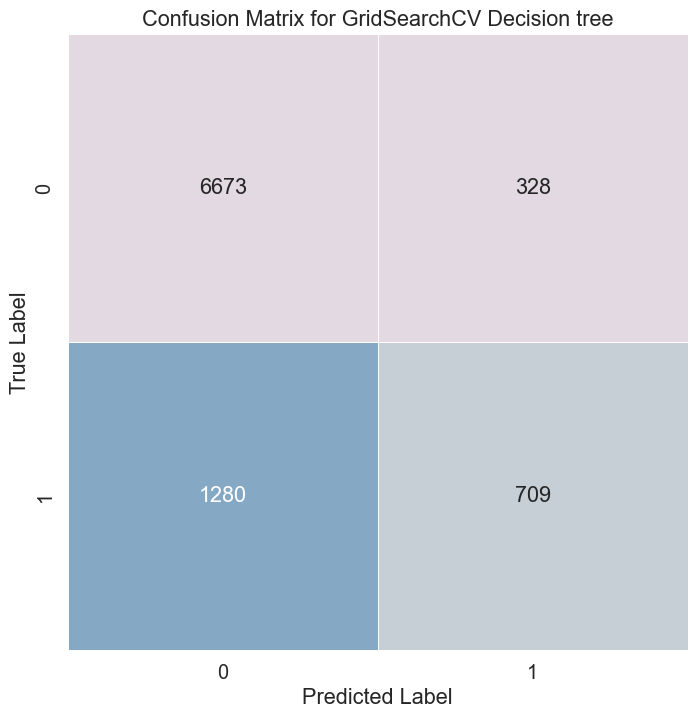

In [37]:
gs_tr_matrix = confusion_matrix(y_test,gs_tree_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(gs_tr_matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for GridSearchCV Decision tree');

In [38]:
gs_tree_probs = gs_tree.predict_proba(X_test)

gs_tree_probs = gs_tree_probs[:, 1]

gs_tree_auc = roc_auc_score(y_test, gs_tree_probs)
print('AUC: %.2f' % gs_tree_auc)

AUC: 0.75


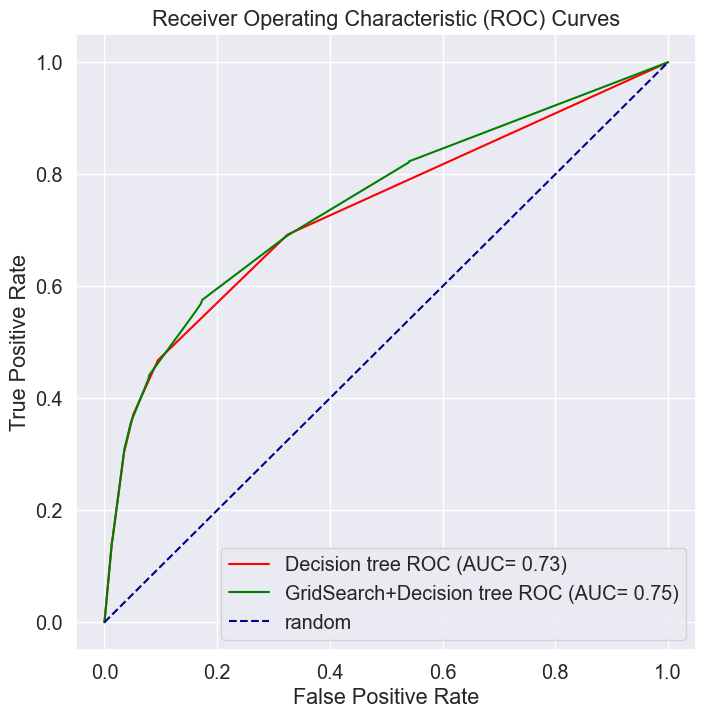

In [39]:
gs_tr_fpr, gs_tr_tpr, gs_tr_thresholds = roc_curve(y_test, gs_tree_probs)
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_test, tr_probs)

plt.figure(figsize=(8,8))
plt.plot(tr_fpr, tr_tpr, color='red', label='Decision tree ROC (AUC= %0.2f)'% auc_tr)
plt.plot(gs_tr_fpr, gs_tr_tpr, color='green', label='GridSearch+Decision tree ROC (AUC= %0.2f)'% gs_tree_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

# 5. Neural network

In [40]:
mlp = MLPClassifier(hidden_layer_sizes=(12,5),max_iter=1000, random_state=25,shuffle=True, verbose=False)

mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(12, 5), max_iter=1000, random_state=25)

In [41]:
mlp_pred = mlp.predict(X_test)

mlp_cv=cross_val_score(mlp, X_train, y_train, cv=10).mean()

Metriki dla Neutral Network (MLP)

In [42]:
print('Accuracy: %.3f' % mlp.score(X_test, y_test))
print('Cross-validation accuracy: %0.3f' % mlp_cv)
print('Precision: %.3f' % precision_score(y_test, mlp_pred))
print('Recall: %.3f' % recall_score(y_test, mlp_pred))
print('F1 score: %.3f' % f1_score(y_test, mlp_pred))

Accuracy: 0.821
Cross-validation accuracy: 0.816
Precision: 0.672
Recall: 0.372
F1 score: 0.479


Porównanie prognozy z wartościami prawdziwymi za pomocą macierzy omyłek

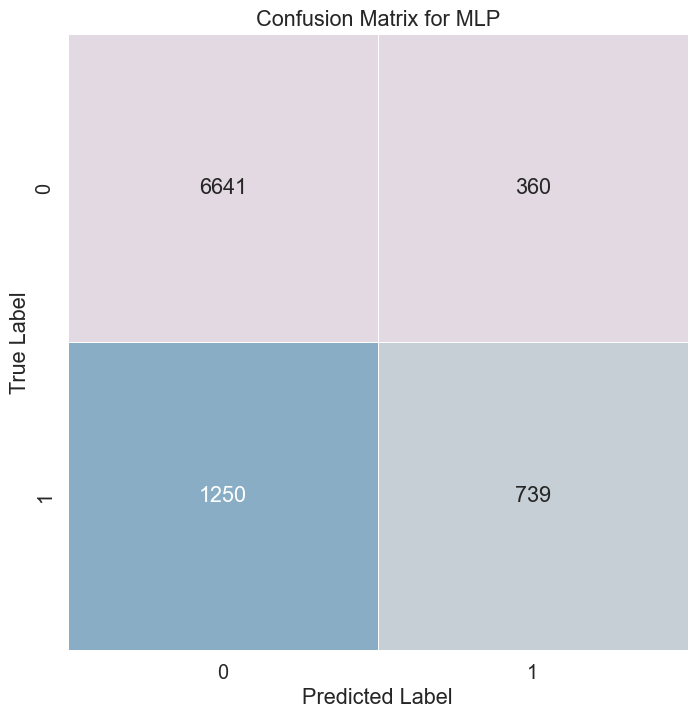

In [43]:
matrix = confusion_matrix(y_test,mlp_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for MLP');

In [44]:
mlp_probs = mlp.predict_proba(X_test)

mlp_probs = mlp_probs[:, 1]

auc_mlp = roc_auc_score(y_test, mlp_probs)
print('AUC: %.2f' % auc_mlp)

AUC: 0.76


# 6. Grid search dla Neural network

In [45]:
parameters = {'activation':['logistic','relu'],
              'solver': ['lbfgs','adam','sgd'],
              'alpha':10.0 ** -np.arange(1,3),
              'hidden_layer_sizes':[(23),(12,5),(12,5,2),(3,1),(5)]}

default_mlp = MLPClassifier(random_state=42)

gs_mlp = GridSearchCV(default_mlp, parameters, cv=10, n_jobs=-1,verbose=10)

gs_mlp.fit(X_train,y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['logistic', 'relu'],
                         'alpha': array([0.1 , 0.01]),
                         'hidden_layer_sizes': [23, (12, 5), (12, 5, 2), (3, 1),
                                                5],
                         'solver': ['lbfgs', 'adam', 'sgd']},
             verbose=10)

In [46]:
gs_mlp_pred=gs_mlp.predict(X_test)

Metryki dla Grid Search MLP:

In [47]:
print("Best MLP Parameters: {}".format(gs_mlp.best_params_))
print('Cross-validation accuracy: %0.3f' % gs_mlp.best_score_)
print('Accuracy: %0.3f' % (gs_mlp.score(X_test,y_test)))
print('Precision: %.3f' % precision_score(y_test, gs_mlp_pred))
print('Recall: %.3f' % recall_score(y_test, gs_mlp_pred))
print('F1 score: %.3f' % f1_score(y_test, gs_mlp_pred))

Best MLP Parameters: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 5, 'solver': 'adam'}
Cross-validation accuracy: 0.821
Accuracy: 0.821
Precision: 0.688
Recall: 0.349
F1 score: 0.463


Porównanie prognozy z wartościami prawdziwymi za pomocą macierzy omyłek

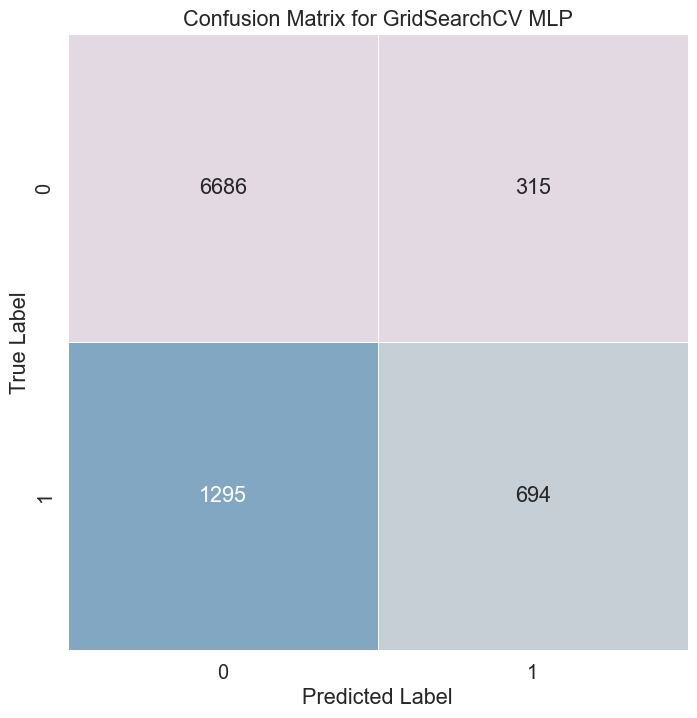

In [48]:
matrix = confusion_matrix(y_test,gs_mlp_pred)
plt.figure(figsize=(8,8))
sns.heatmap(matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for GridSearchCV MLP');

In [49]:
gs_mlp_probs = gs_mlp.predict_proba(X_test)
gs_mlp_probs = gs_mlp_probs[:, 1]
gs_mlp_auc = roc_auc_score(y_test, gs_mlp_probs)
print('AUC: %.2f' % gs_mlp_auc)

AUC: 0.76


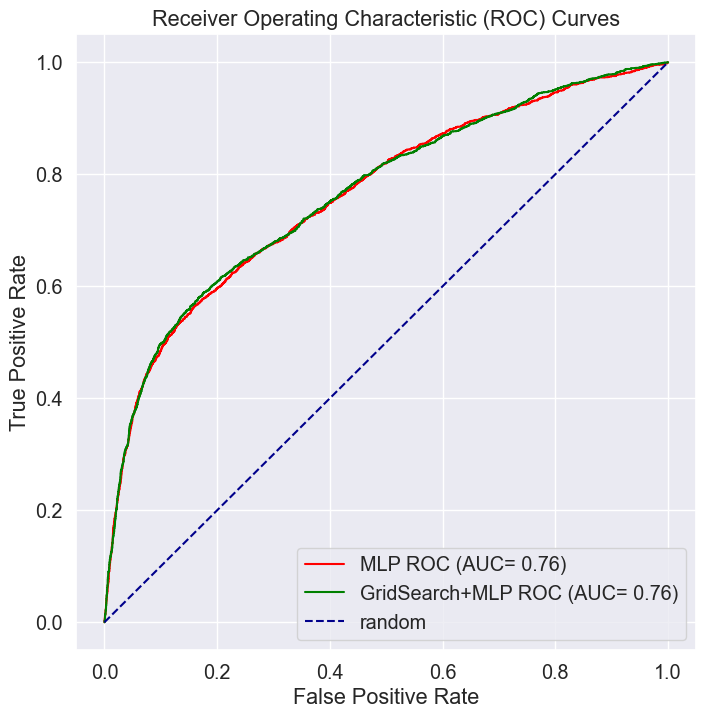

In [50]:
gs_mlp_fpr, gs_mlp_tpr,gs_mlp_thresholds = roc_curve(y_test, gs_mlp_probs)
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(y_test, mlp_probs)

# Plot the ROC curve.
plt.figure(figsize=(8,8))
plt.plot(mlp_fpr, mlp_tpr, color='red', label='MLP ROC (AUC= %0.2f)'% auc_mlp)
plt.plot(gs_mlp_fpr, gs_mlp_tpr, color='green', label='GridSearch+MLP ROC (AUC= %0.2f)'% gs_mlp_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

# Podsumowanie

In [51]:
metrics=['Accuracy', 'CV accuracy', 'Precision','Recall','F1','ROC AUC']

fig = go.Figure(data=[
    go.Bar(name='Logistic Regression', x=metrics,
           y=[modellr.score(X_test, y_test),modellr_cv,precision_score(y_test, lr_pred),recall_score(y_test, lr_pred),f1_score(y_test, lr_pred),auc_modellr]),
    go.Bar(name='Decision tree', x=metrics,
           y=[tr.score(X_test, y_test),tr_cv,precision_score(y_test, tr_pred),recall_score(y_test, tr_pred),f1_score(y_test, tr_pred),auc_tr]),
    go.Bar(name='Neural Network', x=metrics,
           y=[mlp.score(X_test, y_test),mlp_cv,precision_score(y_test, mlp_pred),recall_score(y_test, mlp_pred),f1_score(y_test, mlp_pred),auc_mlp]),
    go.Bar(name='GridSearchCV+Logistic Regression',
           x=metrics, y=[gs_modellr.score(X_test,y_test),gs_modellr.best_score_,precision_score(y_test, gs_log_pred),recall_score(y_test, gs_log_pred),f1_score(y_test, gs_log_pred),gs_modellr_auc]),
    go.Bar(name='GridSearchCV+Decision tree',
           x=metrics, y=[gs_tree.score(X_test,y_test),gs_tree.best_score_,precision_score(y_test, gs_tree_pred),recall_score(y_test, gs_tree_pred), f1_score(y_test, gs_tree_pred),gs_tree_auc]),
    go.Bar(name='GridSearchCV+Neural Network',
           x=metrics, y=[gs_mlp.score(X_test,y_test),gs_mlp.best_score_,precision_score(y_test, gs_mlp_pred),recall_score(y_test, gs_mlp_pred), f1_score(y_test, gs_mlp_pred),gs_mlp_auc]),
    
])

fig.update_layout(title_text='Metrics for each model',
                  barmode='group',xaxis_tickangle=-45,bargroupgap=0.05)
fig.show()

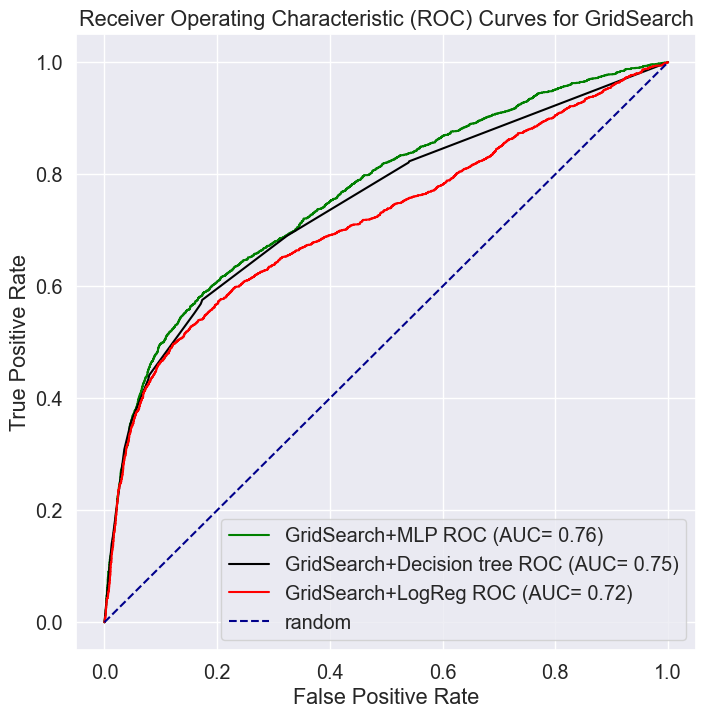

In [52]:
plt.figure(figsize=(8,8))
plt.plot(gs_mlp_fpr, gs_mlp_tpr, color='green', label='GridSearch+MLP ROC (AUC= %0.2f)'% gs_mlp_auc)
plt.plot(gs_tr_fpr, gs_tr_tpr, color='black', label='GridSearch+Decision tree ROC (AUC= %0.2f)'% gs_tree_auc)
plt.plot(gs_modellr_fpr, gs_modellr_tpr, color='red',label='GridSearch+LogReg ROC (AUC= %0.2f)'% gs_modellr_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for GridSearch')
plt.legend()
plt.show()

In [53]:
d={
'': ['Logistic Regression','GridSearchCV + Logistic Regression','Decision Tree','GridSearchCV + Decision Tree','Neural Network (MLP)','GridSearchCV + Neural Network (MLP)'],
'Accuracy': [modellr.score(X_test, y_test), gs_modellr.score(X_test,y_test),tr.score(X_test, y_test),gs_tree.score(X_test,y_test),mlp.score(X_test, y_test),gs_mlp.score(X_test, y_test)],
'CV Accuracy': [modellr_cv, gs_modellr.best_score_, tr_cv,gs_tree.best_score_,mlp_cv,gs_mlp.best_score_],
'Precision': [precision_score(y_test, lr_pred), precision_score(y_test, gs_log_pred),precision_score(y_test, tr_pred),precision_score(y_test, gs_tree_pred),precision_score(y_test, mlp_pred),precision_score(y_test, gs_mlp_pred)],
'Recall': [recall_score(y_test, lr_pred), recall_score(y_test, gs_log_pred),recall_score(y_test, tr_pred),recall_score(y_test, gs_tree_pred),recall_score(y_test, mlp_pred),recall_score(y_test, gs_mlp_pred)],
'F1': [f1_score(y_test, lr_pred), f1_score(y_test, gs_log_pred),f1_score(y_test, tr_pred),f1_score(y_test, gs_tree_pred),f1_score(y_test, mlp_pred),f1_score(y_test, gs_mlp_pred)],
'ROC AUC': [auc_modellr, gs_modellr_auc, auc_tr, gs_tree_auc, auc_mlp, gs_mlp_auc]
}

results=pd.DataFrame(data=d).round(3).set_index('')
results

Accuracy  CV Accuracy  Precision  Recall  \
                                                                                
Logistic Regression                     0.811        0.811      0.729   0.235   
GridSearchCV + Logistic Regression      0.812        0.811      0.730   0.236   
Decision Tree                           0.821        0.819      0.673   0.371   
GridSearchCV + Decision Tree            0.821        0.821      0.684   0.356   
Neural Network (MLP)                    0.821        0.816      0.672   0.372   
GridSearchCV + Neural Network (MLP)     0.821        0.821      0.688   0.349   

                                        F1  ROC AUC  
                                                     
Logistic Regression                  0.356    0.718  
GridSearchCV + Logistic Regression   0.357    0.718  
Decision Tree                        0.478    0.734  
GridSearchCV + Decision Tree         0.469    0.748  
Neural Network (MLP)                 0.479    0.763  
GridSearchCV + Neural Network (MLP)  0.463    0.765